# Running before

In [ ]:
%load_ext autoreload
%autoreload 2
from plot import *
import sys
sys.path.append("../lib")
from matplotlib.colors import LinearSegmentedColormap
import sys 
import numpy as np
import jax
import jax.numpy as jnp
import jax
# jax.config.update("jax_platform_name", "cpu")
import matplotlib.pyplot as plt
rgb_values = [
    [231, 98, 84],
    [239, 138, 71],
    [247, 170, 88],
    [255, 208, 111],
    [255, 230, 183],
    [170, 220, 224],
    [114, 188, 213],
    [82, 143, 173],
    [55, 103, 149],
    [30, 70, 110]
]
colors = [[x / 255 for x in rgb] for rgb in rgb_values]
colors_line = [
    (55/255, 103/255, 149/255),    # #c7522a
    (114/255, 188/255, 213/255),  # #e5c185
    (247/255, 170/255, 88/255),  # #fbf2c4
    (231/255, 98/255, 84/255)     # #008585
]
colors_line2 = [
    (189/255, 60/255, 51/255),    # #c7522a
    (63/255, 96/255, 163/255),  # #e5c185
]
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "text.usetex": False,
    "figure.figsize": (8, 6),
    "axes.linewidth": 2.0,
    "font.size": 20,
    "axes.labelsize": 24,
    "axes.titlesize": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 20,    # tick label
    "ytick.labelsize": 20,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 8,
    "ytick.major.size": 8,
    "xtick.minor.size": 4,
    "ytick.minor.size": 4,
    "xtick.major.width": 2.0,
    "ytick.major.width": 2.0,
    "xtick.minor.width": 1.5,
    "ytick.minor.width": 1.5,
    "axes.labelpad": 6,
    "lines.linewidth": 1.5,
})
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=10)
cmap256 = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
from notion_client import Client
notion = Client(auth="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")
database_id = "1f8fc9067a748057a9ebf052fd25a8bd"
response = notion.databases.query(
    database_id=database_id,
    page_size=100
)


In [2]:
# -*- coding: utf-8 -*-
"""
=========================================================
Phi–Rcusp 4-panel plotter (q vs a4) + Notion observations
=========================================================
What this script does:
- Load two simulation sets: (phi, Rcusp, q) and (phi, Rcusp, a4/a)
- Plot two columns: left colored by q; right colored by a4/a
- Each column has Major-axis and Minor-axis rows
- Overlay Notion observations (optional error bars with label bounds)
- Horizontal colorbar under each column
"""
from notion import get_all_lens_names, get_lens_data_by_name
import math
import matplotlib.patheffects as path_effects
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multipoleprior import sample_multipole_params_given_q
# =========================================================
# =========================================================
def normalize_axis(x):
    if x is None:
        return None
    t = str(x).strip().lower().replace("_", "").replace("-", "").replace(" ", "")
    if t in ("long", "longaxis", "major", "majoraxis"):
        return "long"
    if t in ("short", "shortaxis", "minor", "minoraxis"):
        return "short"
    return None
def marker_from_type_rcusp(v):
    t = (v or "").strip().lower()
    if t == "ratio":
        return "*"
    if t == "jwst":
        return "^"
    return "o"
def size_from_marker(marker):
    return 300 if marker in ("*",) else 120
# =========================================================
# =========================================================
def get_notion_points(seed_for_multipole=1234):
    names = get_all_lens_names(response) or []
    out = []
    n_major, n_minor = 0, 0
    rng_mp = np.random.default_rng(seed_for_multipole)
    for name in names:
        d = get_lens_data_by_name(response, name)
        if not isinstance(d, dict):
            continue
        phi = d.get("phi")
        rcusp = d.get("Rcusp")
        axis = normalize_axis(d.get("axis_type"))
        q_raw = None
        for k in ("q", "q_sie", "q_SIE", "qSIE"):
            if k in d and d.get(k) is not None:
                q_raw = d.get(k)
                break
        try:
            q_val = float(q_raw) if q_raw is not None else np.nan
        except:
            q_val = np.nan
        phi_sig_raw = d.get("phi_sigma", None)
        rcusp_sig_raw = d.get("Rcusp_sigma", None)
        try:
            phi_sigma = float(phi_sig_raw) if phi_sig_raw is not None else np.nan
        except:
            phi_sigma = np.nan
        try:
            rcusp_sigma = float(rcusp_sig_raw) if rcusp_sig_raw is not None else np.nan
        except:
            rcusp_sigma = np.nan
        try:
            phi = float(phi)
            rcusp = float(rcusp)
        except:
            continue
        if not (math.isfinite(phi) and math.isfinite(rcusp)):
            continue
        if phi < PHI_MIN or phi > PHI_MAX:
            continue
        if axis == "long" and not (RCUSP_MIN_LONG <= rcusp <= RCUSP_MAX_LONG):
            continue
        if axis == "short" and not (RCUSP_MIN_SHORT <= rcusp <= RCUSP_MAX_SHORT):
            continue
        marker = "o"
        size = 120
        if axis == "long":
            n_major += 1
        elif axis == "short":
            n_minor += 1
        if not (math.isfinite(phi_sigma) and phi_sigma > 0):
            phi_sigma = np.nan
        if not (math.isfinite(rcusp_sigma) and rcusp_sigma > 0):
            rcusp_sigma = np.nan
        a4_a_val = np.nan
        if math.isfinite(q_val):
            try:
                mp = sample_multipole_params_given_q(np.array([q_val], dtype=float), rng=rng_mp)
                a4_a_val = float(mp["a4_a"][0])
            except Exception:
                a4_a_val = np.nan
        out.append({
            "name": name,
            "phi": phi,
            "rcusp": rcusp,
            "axis": axis,
            "marker": marker,
            "size": size,
            "q": q_val,
            "a4_a": a4_a_val,
            "phi_sigma": phi_sigma,
            "rcusp_sigma": rcusp_sigma,
        })
    return out, n_major, n_minor
# =========================================================
# =========================================================
def load_params_generic(base, wrap_phi_to_180=True, mode="q"):
    rows = []
    for name in sorted(os.listdir(base), key=lambda s: int(s) if s.isdigit() else 10**12):
        if not name.isdigit():
            continue
        sub = os.path.join(base, name, "0")
        if not os.path.isdir(sub):
            continue
        target = os.path.join(sub, f"all_sim_{name}_params.json")
        if not os.path.isfile(target):
            cands = [f for f in os.listdir(sub) if f.endswith("_params.json")]
            if not cands:
                continue
            target = os.path.join(sub, cands[0])
        try:
            d = json.load(open(target))
        except:
            continue
        phi = d.get("phi", np.nan)
        if wrap_phi_to_180 and np.isfinite(phi):
            phi = phi % 360
            if phi > 180:
                phi = 360 - phi
        rows.append({
            "axis_type": d.get("axis_type", "unknown"),
            "phi": phi,
            "Rcusp": d.get("Rcusp", np.nan),
            "var": d.get("q", np.nan) if mode == "q" else d.get("a4_over_a_signed", np.nan),
        })
    df = pd.DataFrame(rows)
    m = (
        df["axis_type"].isin(["long_axis", "short_axis"]) &
        np.isfinite(df["phi"]) &
        np.isfinite(df["Rcusp"]) &
        np.isfinite(df["var"])
    )
    return df[m].reset_index(drop=True)
# =========================================================
# =========================================================
def draw_two_rows(
    fig, left, bottom, width, height, df, label_var,
    reverse_cbar=False, remove_ylabel=False,
    notion_points=None,
    notion_color_key=None,
    gap_frac=0.06,
    cbar_height=0.020,
    cbar_gap=0.055,
    phi_minor_min=60,
    phi_minor_max=150,
    cmap=None,
):
    dL = df[df.axis_type == "long_axis"]
    dS = df[df.axis_type == "short_axis"]
    vmin_, vmax_ = df["var"].min(), df["var"].max()
    cmap_use = plt.get_cmap(cmap) if cmap else (
        cmap256.reversed() if reverse_cbar else cmap256
    )
    gap = height * gap_frac
    h_minor = height * 0.28
    h_major = height - h_minor - gap
    # =====================================================
    # [Sub-block 4.1] Major (Long axis)
    # =====================================================
    axL = fig.add_axes([left, bottom + h_minor + gap, width, h_major])
    scL = axL.scatter(
        dL["phi"], dL["Rcusp"], s=50, alpha=0.9,
        c=dL["var"], cmap=cmap_use, vmin=vmin_, vmax=vmax_
    )
    axL.set_xlim(PHI_MIN, PHI_MAX)
    axL.set_ylim(RCUSP_MIN_LONG, RCUSP_MAX_LONG)
    if not remove_ylabel:
        axL.set_ylabel("$R_{cusp}$")
    else:
        axL.set_ylabel("")
        axL.set_yticks([])
        axL.tick_params(axis="y", which="both", left=False, labelleft=False)
    axL.text(0.02, 0.98, "Major-axis", transform=axL.transAxes,
             ha="left", va="top")
    # =====================================================
    # [Sub-block 4.2] Minor (Short axis)
    # =====================================================
    axS = fig.add_axes([left, bottom, width, h_minor])
    scS = axS.scatter(
        dS["phi"], dS["Rcusp"], s=50, alpha=0.9,
        c=dS["var"], cmap=cmap_use, vmin=vmin_, vmax=vmax_
    )
    axS.set_xlim(phi_minor_min, phi_minor_max)
    axS.set_ylim(RCUSP_MIN_SHORT, RCUSP_MAX_SHORT)
    axS.set_xlabel("$\\phi$")
    if not remove_ylabel:
        axS.set_ylabel("$R_{cusp}$")
        ticks = axS.get_yticks()
        ticks = [t for t in ticks if t < RCUSP_MAX_SHORT]
        axS.set_yticks(ticks)
    else:
        axS.set_ylabel("")
        axS.set_yticks([])
        axS.tick_params(axis="y", which="both", left=False, labelleft=False)
    axS.text(0.02, 0.95, "Minor-axis", transform=axS.transAxes,
             ha="left", va="top")
    # =====================================================
    # =====================================================
    if notion_points is None:
        notion_points = []
    colorize_notion_by_q = (remove_ylabel is False)
    def _label_offset(ax, x, y):
        """
        Return (dx, dy, ha, va): offset labels toward the plot to stay inside.
        dx and dy are in points
        """
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        xr = x1 - x0
        yr = y1 - y0
        dx, dy = 0, 6
        ha, va = "center", "bottom"
        if xr > 0:
            if x < x0 + 0.08 * xr:
                dx, ha = 10, "left"
            elif x > x1 - 0.08 * xr:
                dx, ha = -10, "right"
        if yr > 0 and y > y1 - 0.10 * yr:
            dy, va = -8, "top"
        if yr > 0 and y < y0 + 0.10 * yr:
            dy, va = 10, "bottom"
        return dx, dy, ha, va
    placed_long = []
    placed_short = []
    phi_thresh_long, rcusp_thresh_long = 6.0, 0.04
    phi_thresh_short, rcusp_thresh_short = 6.0, 0.04
    dy_step = 10
    for e in notion_points:
        ax = axL if e.get("axis") == "long" else axS if e.get("axis") == "short" else None
        if ax is None:
            continue
        key = notion_color_key  # 'q' or 'a4_a'
        if key is not None and np.isfinite(e.get(key, np.nan)):
            if vmax_ > vmin_:
                face = cmap_use((e[key] - vmin_) / (vmax_ - vmin_))
            else:
                face = cmap_use(0.5)
        else:
            face = "#DAA520"
        x = e["phi"]
        y = e["rcusp"]
        xerr = e.get("phi_sigma", np.nan)
        yerr = e.get("rcusp_sigma", np.nan)
        _xerr = xerr if np.isfinite(xerr) else None
        _yerr = yerr if np.isfinite(yerr) else None
        if (_xerr is not None):
            ax.plot([x - _xerr, x + _xerr], [y, y],
                    color="black", lw=1.2, alpha=0.9, zorder=10,
                    solid_capstyle="round", clip_on=True)
        if (_yerr is not None):
            ax.plot([x, x], [y - _yerr, y + _yerr],
                    color="black", lw=1.2, alpha=0.9, zorder=10,
                    solid_capstyle="round", clip_on=True)
        ax.scatter([x], [y],
                   edgecolors="black", marker="o",
                   s=e.get("size", 120),
                   facecolors=face, linewidths=1.2,
                   alpha=0.98, zorder=3, clip_on=True)
        # =====================================================
        # =====================================================
        name = str(e.get("name", ""))
        dx, dy, ha, va = _label_offset(ax, x, y)
        if name in LABEL_OFFSET_POINTS:
            dx0, dy0 = LABEL_OFFSET_POINTS[name]
            dx, dy = dx0, dy0
        if name in LABEL_ALIGN:
            ha = LABEL_ALIGN[name].get("ha", ha)
            va = LABEL_ALIGN[name].get("va", va)
        placed = placed_long if ax is axL else placed_short
        if ax is axL:
            phi_th, r_th = phi_thresh_long, rcusp_thresh_long
        else:
            phi_th, r_th = phi_thresh_short, rcusp_thresh_short
        nudge_level = 0
        for (px, py) in placed:
            if (abs(x - px) < phi_th) and (abs(y - py) < r_th):
                nudge_level += 1
        if nudge_level > 0:
            dy = dy + nudge_level * dy_step
        placed.append((x, y))
        ann = ax.annotate(
            name,
            xy=(x, y),
            xytext=(dx, dy),
            textcoords="offset points",
            fontsize=14,
            ha=ha, va=va,
            color="black",
            zorder=4,
            clip_on=True,
            # bbox=dict(boxstyle="round,pad=0.12", fc="white", ec="none", alpha=0.75),
        )
        ann.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground="white"),
            path_effects.Normal()
        ])
    # =====================================================
    # =====================================================
    cbar_bottom = bottom - cbar_gap - cbar_height
    cax = fig.add_axes([left, cbar_bottom, width, cbar_height])
    cbar = fig.colorbar(scL, cax=cax, orientation="horizontal")
    cbar.set_label(label_var)
    return axL, axS, cax


In [3]:
def plot_q_a4_distributions(df, save_path="filtered_q_a4_distributions.png"):
    import numpy as np
    import matplotlib.pyplot as plt
    def kde_pdf(x, data, grids=512, cut=0.05):
        data = np.asarray([v for v in data if np.isfinite(v)])
        if data.size < 2:
            xgrid = np.linspace(-1, 1, grids) if x is None else x
            return xgrid, np.zeros_like(xgrid)
        try:
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(data)
            lo = np.quantile(data, cut)
            hi = np.quantile(data, 1 - cut)
            xgrid = np.linspace(lo, hi, grids) if x is None else x
            return xgrid, kde(xgrid)
        except Exception:
            lo = np.quantile(data, cut)
            hi = np.quantile(data, 1 - cut)
            hist_y, bin_edges = np.histogram(data, bins=80, range=(lo, hi), density=True)
            xgrid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            bw = max(1, int(0.02 * len(hist_y)))
            g = np.exp(-0.5 * (np.arange(-3*bw, 3*bw+1) / max(bw, 1))**2); g /= g.sum()
            y = np.convolve(hist_y, g, mode="same")
            return xgrid, y
    def _overlay(ax, arr_long, arr_short, xlabel, xlim=None, kde_cut=0.02):
        L = np.array([v for v in arr_long if np.isfinite(v)])
        S = np.array([v for v in arr_short if np.isfinite(v)])
        if L.size + S.size == 0:
            ax.set_xlabel(xlabel); ax.set_ylabel("PDF"); return
        allv = np.concatenate([L, S]) if L.size and S.size else (L if L.size else S)
        lo = np.quantile(allv, kde_cut)
        hi = np.quantile(allv, 1 - kde_cut)
        if xlim is None:
            xgrid = np.linspace(lo, hi, 600)
        else:
            xgrid = np.linspace(xlim[0], xlim[1], 600)
        xL, yL = kde_pdf(xgrid, L, grids=len(xgrid), cut=kde_cut)
        xS, yS = kde_pdf(xgrid, S, grids=len(xgrid), cut=kde_cut)
        ax.fill_between(xL, 0, yL, alpha=0.5, label="Major axis", color = colors[0])
        ax.plot(xL, yL, lw=1.5, color = colors[0])
        poly = ax.fill_between(xS, 0, yS, alpha=0.5, label="Minor axis", color = colors[-3])
        poly.set_hatch("///")
        ax.plot(xS, yS, lw=1.5,color = colors[-3])
        ax.set_xlabel(xlabel)
        ax.set_ylabel("PDF")
        ax.legend(frameon=True)
    dfL = df[df.axis_type == "long_axis"]
    dfS = df[df.axis_type == "short_axis"]
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    ax0, ax1 = axes
    _overlay(ax0,
             dfL["q"].values, dfS["q"].values,
             xlabel=r"Axis Ratio $q$",
             xlim=(0.1, 1.0))
    def symmetric_xlim(col):
        arr = df[col].to_numpy()
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            return None
        m = np.nanquantile(np.abs(arr), 0.99)
        if not np.isfinite(m) or m == 0:
            return None
        m *= 1.05
        return (-m, m)
    _overlay(ax1,
             dfL["a4_over_a_signed"].values, dfS["a4_over_a_signed"].values,
             xlabel=r"$a_4/a$ (signed)",
             xlim=symmetric_xlim("a4_over_a_signed"))
    fig.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"OK Saved: {save_path}")


Loaded 248 records (long_axis=204, short_axis=44)
✅ Saved: all_simMul_stats.png
✅ Saved: all_simMul_m3m4_stats.png


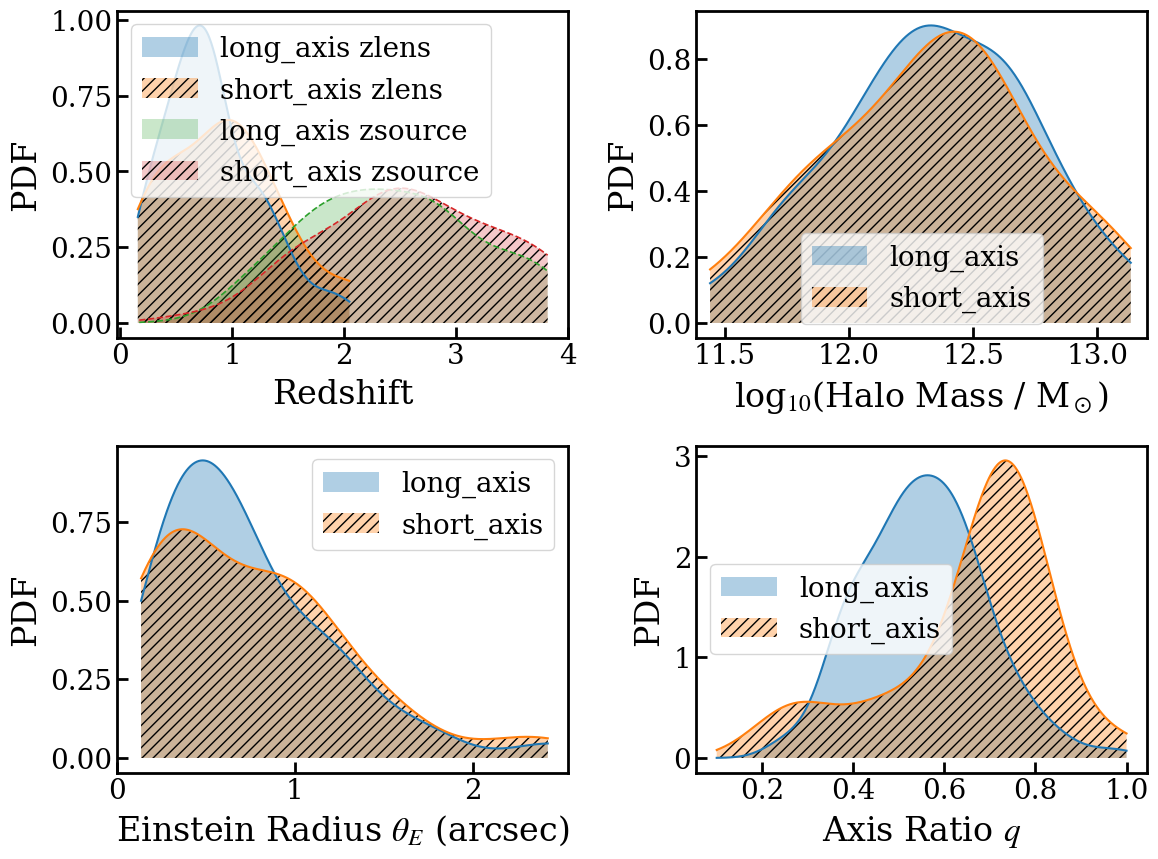

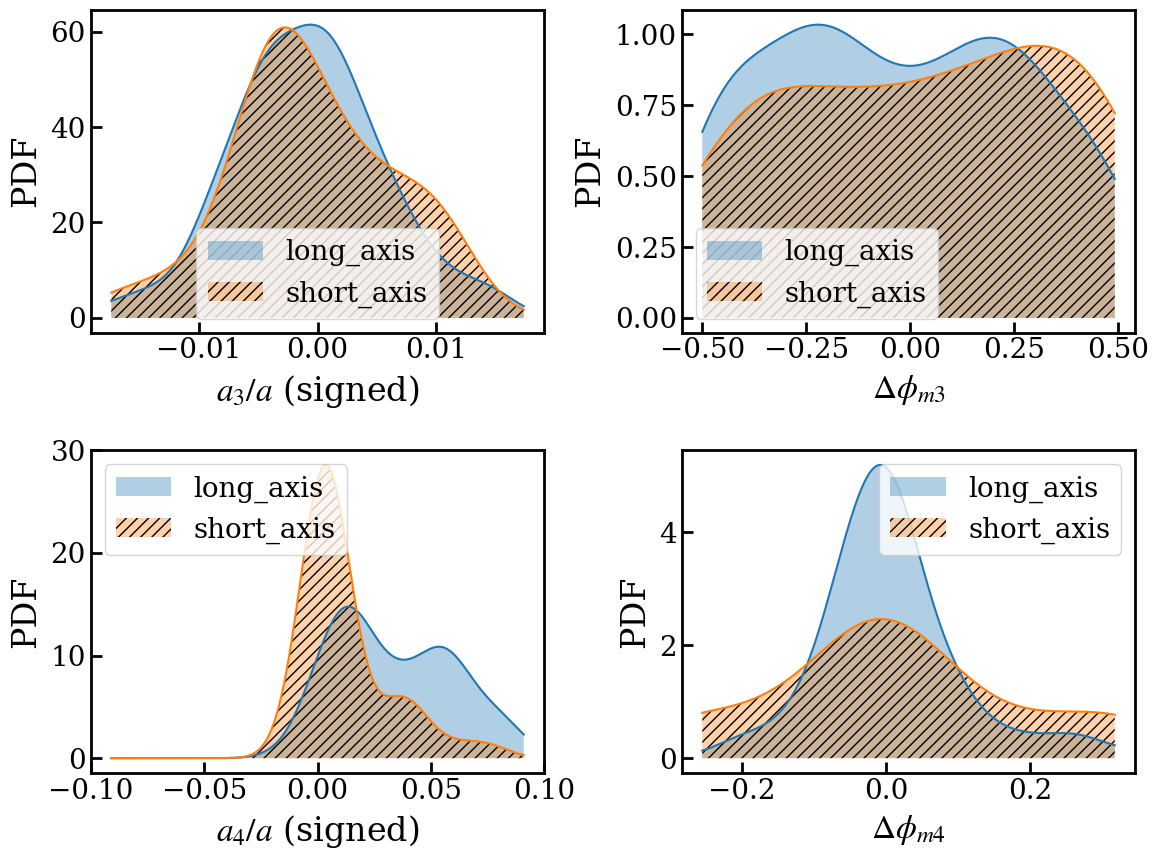

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Load mock-lens parameters from JSON files and plot 1D distributions (KDE / smoothed histogram)
for long-axis vs short-axis samples.
Outputs:
  - all_simMul_stats.png            : zlens/zsource, log10(M), thetaE, q
  - all_simMul_m3m4_stats.png       : a3/a, dphi_m3, a4/a, dphi_m4
"""
# =============================================================================
# 0) Imports
# =============================================================================
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# =============================================================================
# 1) PDF estimator: KDE (scipy) with fallback to smoothed histogram
# =============================================================================
def kde_pdf(xgrid, data, grids=512, cut=0.05, hist_bins=80):
    """
    Return (x, pdf(x)) for a 1D sample.
    - Prefer scipy.stats.gaussian_kde
    - Fallback: normalized histogram + simple Gaussian smoothing
    """
    data = np.asarray([v for v in data if np.isfinite(v)], dtype=float)
    # Edge cases
    if data.size < 2:
        x = np.linspace(0.0, 1.0, grids) if xgrid is None else np.asarray(xgrid, dtype=float)
        return x, np.zeros_like(x)
    # Robust range
    lo = np.quantile(data, cut)
    hi = np.quantile(data, 1.0 - cut)
    x = np.linspace(lo, hi, grids) if xgrid is None else np.asarray(xgrid, dtype=float)
    # KDE path
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(data)
        return x, kde(x)
    except Exception:
        # Fallback: smoothed histogram
        hist_y, bin_edges = np.histogram(data, bins=hist_bins, range=(lo, hi), density=True)
        xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        # Simple Gaussian kernel (bandwidth tied to number of bins)
        bw = max(1, int(0.02 * len(hist_y)))
        kx = np.arange(-3 * bw, 3 * bw + 1)
        g = np.exp(-0.5 * (kx / max(bw, 1)) ** 2)
        g /= g.sum()
        ys = np.convolve(hist_y, g, mode="same")
        # Interpolate to requested x if needed
        if xgrid is None:
            return xc, ys
        else:
            y = np.interp(x, xc, ys, left=0.0, right=0.0)
            return x, y
# =============================================================================
# 2) Data loader: scan folders and parse JSON -> DataFrame
# =============================================================================
def load_params(base="Theory_Mock/all_sim_Mul"):
    """
    Folder structure assumed:
      base/<id>/0/all_sim_<id>_params.json
    If missing, will pick the first *_params.json under base/<id>/0/
    Returns a DataFrame filtered to axis_type in {"long_axis", "short_axis"}.
    """
    if not os.path.isdir(base):
        raise FileNotFoundError(f"Base folder not found: {base}")
    recs = []
    for name in sorted(os.listdir(base), key=lambda s: int(s) if s.isdigit() else 10**18):
        if not name.isdigit():
            continue
        i = int(name)
        subdir = os.path.join(base, name, "0")
        if not os.path.isdir(subdir):
            continue
        # Primary expected filename
        path = os.path.join(subdir, f"all_sim_{i}_params.json")
        # Fallback: first *_params.json
        if not os.path.isfile(path):
            cand = [f for f in os.listdir(subdir) if f.endswith("_params.json")]
            if not cand:
                continue
            path = os.path.join(subdir, cand[0])
        # Load JSON
        try:
            with open(path, "r") as f:
                d = json.load(f)
        except Exception as e:
            print(f"Skip broken JSON: {path} ({e})")
            continue
        halomass = d.get("halomass", np.nan)
        log10_halomass = np.log10(halomass) if np.isfinite(halomass) and halomass > 0 else np.nan
        recs.append(
            {
                "id": i,
                "axis_type": d.get("axis_type", "unknown"),
                # --- redshifts ---
                "zlens": d.get("zlens", np.nan),
                "zsource": d.get("zsource", np.nan),
                # --- mass / macro ---
                "halomass": halomass,
                "log10_halomass": log10_halomass,
                "thetaE": d.get("thetaE", np.nan),
                "q": d.get("q", np.nan),
                # --- external shear ---
                "gamma_external": d.get("gamma_external", np.nan),
                # --- multipoles ---
                "a3_over_a_signed": d.get("a3_over_a_signed", np.nan),
                "delta_phi_m3": d.get("delta_phi_m3", np.nan),
                "a4_over_a_signed": d.get("a4_over_a_signed", np.nan),
                "delta_phi_m4": d.get("delta_phi_m4", np.nan),
            }
        )
    df = pd.DataFrame.from_records(recs)
    df = df[df["axis_type"].isin(["long_axis", "short_axis"])].copy()
    return df
# =============================================================================
# 3) Plot helper: overlay long/short axis PDFs with hatch
# =============================================================================
def overlay_two_axis_pdf(
    ax,
    arr_long,
    arr_short,
    xlabel,
    kde_cut=0.02,
    xlim=None,
    label_long="long_axis",
    label_short="short_axis",
    hatch_short="///",
    alpha_fill=0.35,
    lw=1.5,
):
    """
    Plot two PDFs (long vs short) on the same axis:
      - long: filled + boundary
      - short: filled + boundary + hatch
    """
    L = np.asarray([v for v in arr_long if np.isfinite(v)], dtype=float)
    S = np.asarray([v for v in arr_short if np.isfinite(v)], dtype=float)
    if L.size + S.size == 0:
        ax.set_xlabel(xlabel)
        ax.set_ylabel("PDF")
        return
    # Common x-grid
    allv = np.concatenate([L, S]) if (L.size and S.size) else (L if L.size else S)
    if xlim is None:
        lo = np.quantile(allv, kde_cut)
        hi = np.quantile(allv, 1.0 - kde_cut)
        xgrid = np.linspace(lo, hi, 600)
    else:
        xgrid = np.linspace(xlim[0], xlim[1], 600)
    xL, yL = kde_pdf(xgrid, L, grids=len(xgrid), cut=kde_cut)
    xS, yS = kde_pdf(xgrid, S, grids=len(xgrid), cut=kde_cut)
    ax.fill_between(xL, 0, yL, alpha=alpha_fill, label=label_long)
    ax.plot(xL, yL, lw=lw)
    poly = ax.fill_between(xS, 0, yS, alpha=alpha_fill, label=label_short)
    poly.set_hatch(hatch_short)
    ax.plot(xS, yS, lw=lw)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("PDF")
    ax.legend(frameon=True)
# =============================================================================
# 4) Plot: basic distributions (z, logM, thetaE, q)
# =============================================================================
def plot_distributions(df, save_path="all_simMul_stats.png"):
    """
    2x2:
      (0,0) Redshift: plot zlens (solid) and zsource (dashed)
      (0,1) log10(M)
      (1,0) thetaE
      (1,1) q
    """
    dfL = df[df.axis_type == "long_axis"]
    dfS = df[df.axis_type == "short_axis"]
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    ax00, ax01, ax10, ax11 = axes.ravel()
    # --- (0,0) redshift panel: first zlens (solid) ---
    overlay_two_axis_pdf(
        ax00,
        dfL["zlens"].values,
        dfS["zlens"].values,
        xlabel="Redshift",
        label_long="long_axis zlens",
        label_short="short_axis zlens",
    )
    # Then zsource (dashed) with the same hatch logic
    # Use a consistent x-range based on both (zlens + zsource) for readability
    z_all = np.concatenate(
        [
            dfL["zlens"].to_numpy(dtype=float),
            dfS["zlens"].to_numpy(dtype=float),
            dfL["zsource"].to_numpy(dtype=float),
            dfS["zsource"].to_numpy(dtype=float),
        ]
    )
    z_all = z_all[np.isfinite(z_all)]
    if z_all.size > 0:
        lo = np.quantile(z_all, 0.02)
        hi = np.quantile(z_all, 0.98)
        xgrid = np.linspace(lo, hi, 600)
        xL, yL = kde_pdf(xgrid, dfL["zsource"].values, grids=len(xgrid), cut=0.02)
        xS, yS = kde_pdf(xgrid, dfS["zsource"].values, grids=len(xgrid), cut=0.02)
        ax00.fill_between(xL, 0, yL, alpha=0.25, label="long_axis zsource")
        ax00.plot(xL, yL, lw=1.2, linestyle="--")
        poly = ax00.fill_between(xS, 0, yS, alpha=0.25, label="short_axis zsource")
        poly.set_hatch("///")
        ax00.plot(xS, yS, lw=1.2, linestyle="--")
        ax00.legend(frameon=True, loc="upper left")
    # --- (0,1) log10 halo mass ---
    overlay_two_axis_pdf(
        ax01,
        dfL["log10_halomass"].values,
        dfS["log10_halomass"].values,
        xlabel=r"log$_{10}$(Halo Mass / M$_\odot$)",
    )
    if np.isfinite(df["log10_halomass"]).any():
        ax01.set_xlim(
            np.nanquantile(df["log10_halomass"], 0.01),
            np.nanquantile(df["log10_halomass"], 0.99),
        )
    # --- (1,0) thetaE ---
    overlay_two_axis_pdf(
        ax10,
        dfL["thetaE"].values,
        dfS["thetaE"].values,
        xlabel=r"Einstein Radius $\theta_E$ (arcsec)",
    )
    ax10.set_xlim(left=0)
    # --- (1,1) q ---
    overlay_two_axis_pdf(
        ax11,
        dfL["q"].values,
        dfS["q"].values,
        xlabel=r"Axis Ratio $q$",
        xlim=(0.1, 1.0),
    )
    fig.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"OK Saved: {save_path}")
# =============================================================================
# 5) Plot: m=3/4 multipole distributions
# =============================================================================
def plot_multipole_distributions(df, save_path="all_simMul_m3m4_stats.png"):
    """
    2x2:
      (0,0) a3/a (signed)     with symmetric xlim
      (0,1) delta_phi_m3
      (1,0) a4/a (signed)     with symmetric xlim
      (1,1) delta_phi_m4
    """
    dfL = df[df.axis_type == "long_axis"]
    dfS = df[df.axis_type == "short_axis"]
    def symmetric_xlim(col):
        arr = df[col].to_numpy(dtype=float)
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            return None
        m = np.nanquantile(np.abs(arr), 0.99)
        if not np.isfinite(m) or m <= 0:
            return None
        m *= 1.05
        return (-m, m)
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    ax00, ax01, ax10, ax11 = axes.ravel()
    overlay_two_axis_pdf(
        ax00,
        dfL["a3_over_a_signed"].values,
        dfS["a3_over_a_signed"].values,
        xlabel=r"$a_3/a$ (signed)",
        xlim=symmetric_xlim("a3_over_a_signed"),
    )
    overlay_two_axis_pdf(
        ax01,
        dfL["delta_phi_m3"].values,
        dfS["delta_phi_m3"].values,
        xlabel=r"$\Delta\phi_{m3}$",
    )
    overlay_two_axis_pdf(
        ax10,
        dfL["a4_over_a_signed"].values,
        dfS["a4_over_a_signed"].values,
        xlabel=r"$a_4/a$ (signed)",
        xlim=symmetric_xlim("a4_over_a_signed"),
    )
    overlay_two_axis_pdf(
        ax11,
        dfL["delta_phi_m4"].values,
        dfS["delta_phi_m4"].values,
        xlabel=r"$\Delta\phi_{m4}$",
    )
    fig.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"OK Saved: {save_path}")
# =============================================================================
# 6) Entry point
# =============================================================================
def main():
    # (A) Load
    df = load_params("Theory_Mock/all_sim_Mul")
    if df.empty:
        raise RuntimeError("No valid records found.")
    print(
        f"Loaded {len(df)} records "
        f"(long_axis={int((df.axis_type=='long_axis').sum())}, "
        f"short_axis={int((df.axis_type=='short_axis').sum())})"
    )
    # (B) Plot
    plot_distributions(df, save_path="all_simMul_stats.png")
    plot_multipole_distributions(df, save_path="all_simMul_m3m4_stats.png")
    # NOTE:
    # Your original code called plot_q_a4_distributions(df, ...), but that function
    # is not defined in the snippet you provided. If you want it, paste that function
    # (or tell me its expected behavior), and I will integrate it in the same style.
if __name__ == "__main__":
    main()

Loaded 248 records (long_axis=204, short_axis=44)


✅ Saved: all_simMul_stats.png
✅ Saved: all_simMul_m3m4_stats.png
✅ Saved: filtered_q_a4_distributions.png


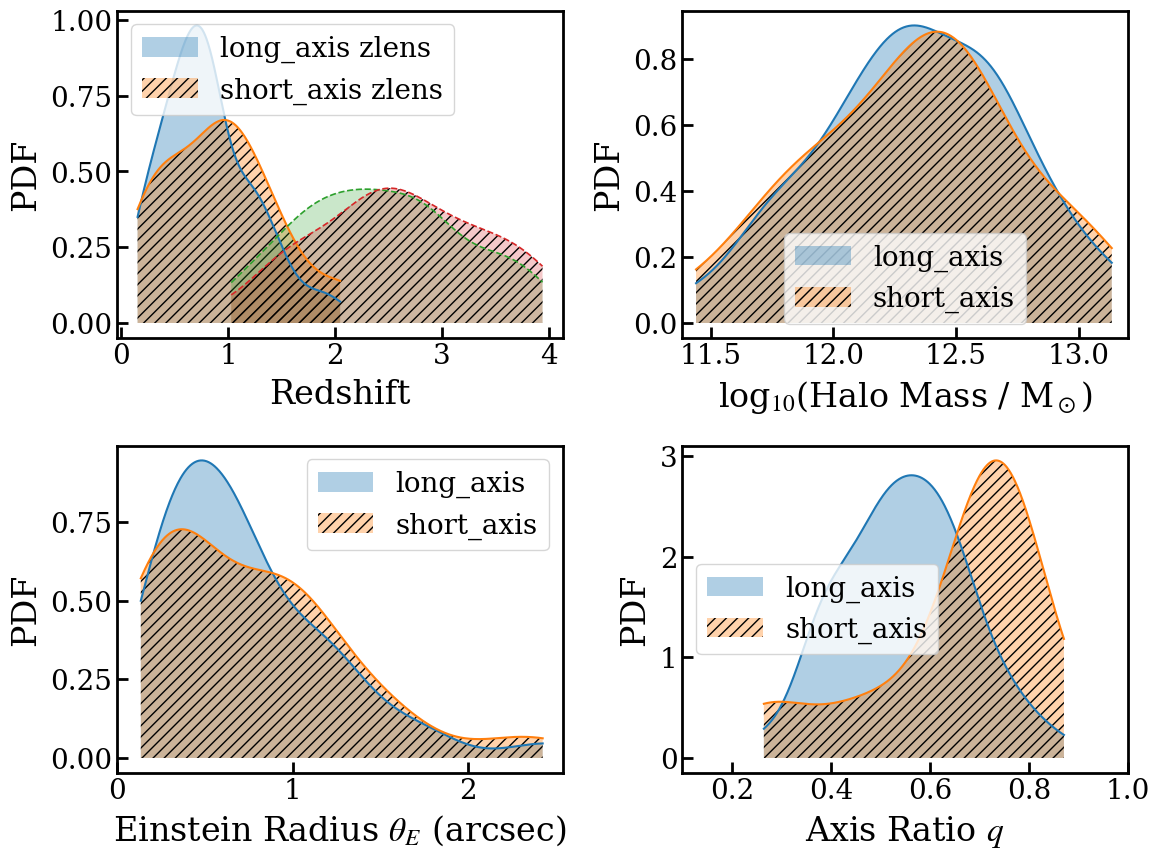

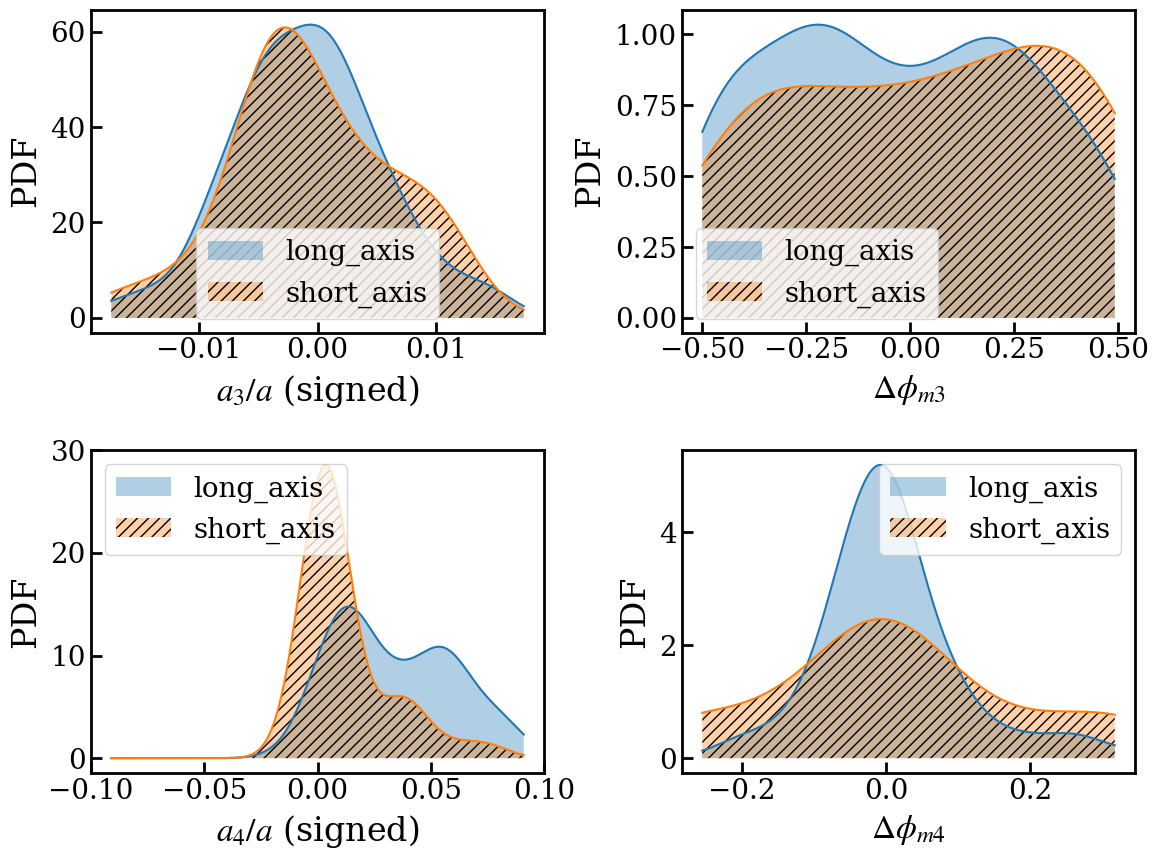

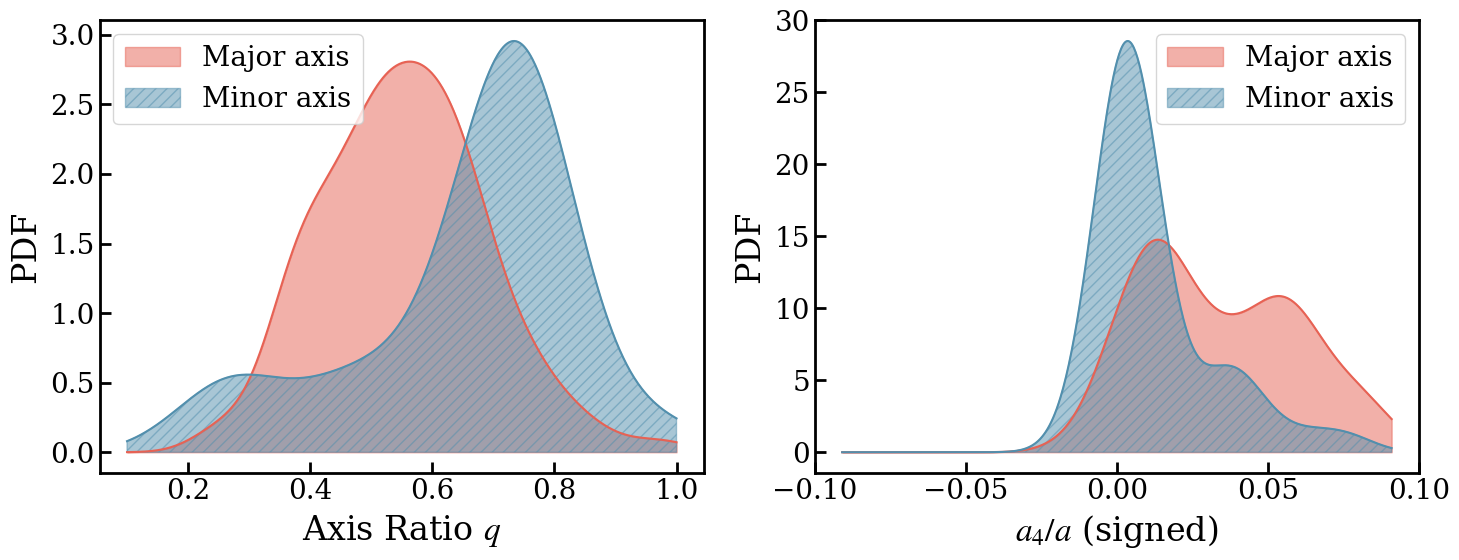

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os, re, json, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def kde_pdf(x, data, grids=512, cut=0.05):
    data = np.asarray([v for v in data if np.isfinite(v)])
    if data.size < 2:
        xgrid = np.linspace(0.0, 1.0, grids) if x is None else x
        return xgrid, np.zeros_like(xgrid)
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(data)
        lo = np.quantile(data, cut)
        hi = np.quantile(data, 1 - cut)
        xgrid = np.linspace(lo, hi, grids) if x is None else x
        return xgrid, kde(xgrid)
    except Exception:
        lo = np.quantile(data, cut)
        hi = np.quantile(data, 1 - cut)
        hist_y, bin_edges = np.histogram(data, bins=80, range=(lo, hi), density=True)
        xgrid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        bw = max(1, int(0.02 * len(hist_y)))
        g = np.exp(-0.5 * (np.arange(-3*bw, 3*bw+1) / max(bw, 1))**2)
        g /= g.sum()
        y = np.convolve(hist_y, g, mode="same")
        return xgrid, y
def load_params(base="Theory_Mock/all_sim_Mul"):
    recs = []
    if not os.path.isdir(base):
        raise FileNotFoundError(f"Base folder not found: {base}")
    for name in sorted(os.listdir(base), key=lambda s: int(s) if s.isdigit() else 1e18):
        if not name.isdigit():
            continue
        i = int(name)
        path = os.path.join(base, name, "0", f"all_sim_{i}_params.json")
        if not os.path.isfile(path):
            cand = [f for f in os.listdir(os.path.join(base, name, "0"))
                    if f.endswith("_params.json")]
            if cand:
                path = os.path.join(base, name, "0", cand[0])
            else:
                continue
        with open(path, "r") as f:
            try:
                d = json.load(f)
            except Exception as e:
                print(f"Skip broken JSON: {path} ({e})")
                continue
        recs.append({
            "id": i,
            "axis_type": d.get("axis_type", "unknown"),
            "zlens": d.get("zlens", np.nan),
            "zsource": d.get("zsource", np.nan),
            "halomass": d.get("halomass", np.nan),
            "log10_halomass": np.log10(d["halomass"]) if np.isfinite(d.get("halomass", np.nan)) and d["halomass"]>0 else np.nan,
            "thetaE": d.get("thetaE", np.nan),
            "q": d.get("q", np.nan),
            "a3_over_a_signed": d.get("a3_over_a_signed", np.nan),
            "delta_phi_m3":     d.get("delta_phi_m3",     np.nan),
            "a4_over_a_signed": d.get("a4_over_a_signed", np.nan),
            "delta_phi_m4":     d.get("delta_phi_m4",     np.nan),
        })
    df = pd.DataFrame.from_records(recs)
    df = df[df["axis_type"].isin(["long_axis", "short_axis"])]
    return df
def plot_distributions(df, save_path="all_simMul_stats.png"):
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    ax00, ax01, ax10, ax11 = axes.ravel()
    def overlay(ax, arr_long, arr_short, xlabel, hatch_label=("long_axis", "short_axis"),
                dashed_for=None, xlim=None, kde_cut=0.02):
        long_clean = np.array([v for v in arr_long if np.isfinite(v)])
        short_clean = np.array([v for v in arr_short if np.isfinite(v)])
        allv = np.concatenate([long_clean, short_clean]) if long_clean.size and short_clean.size else \
               (long_clean if long_clean.size else short_clean)
        if allv.size == 0:
            ax.set_xlabel(xlabel); ax.set_ylabel("PDF"); return
        lo = np.quantile(allv, kde_cut)
        hi = np.quantile(allv, 1 - kde_cut)
        xgrid = np.linspace(lo, hi, 600)
        # KDE
        xL, yL = kde_pdf(xgrid, long_clean, grids=len(xgrid), cut=kde_cut)
        xS, yS = kde_pdf(xgrid, short_clean, grids=len(xgrid), cut=kde_cut)
        ax.fill_between(xL, 0, yL, alpha=0.35, label=hatch_label[0])
        ax.plot(xL, yL, lw=1.5)
        poly = ax.fill_between(xS, 0, yS, alpha=0.35, label=hatch_label[1])
        poly.set_hatch("///")
        ax.plot(xS, yS, lw=1.5)
        if dashed_for == "source":
            for l in ax.lines[-1:]:
                l.set_linestyle("--")
        ax.set_xlabel(xlabel)
        ax.set_ylabel("PDF")
        if xlim is not None:
            ax.set_xlim(*xlim)
        ax.legend(frameon=True)
    dfL = df[df.axis_type == "long_axis"]
    dfS = df[df.axis_type == "short_axis"]
    overlay(ax00, dfL["zlens"].values, dfS["zlens"].values, xlabel="Redshift")
    xgrid, yL_src = kde_pdf(None, dfL["zsource"].values, grids=600, cut=0.02)
    _,     yS_src = kde_pdf(xgrid, dfS["zsource"].values, grids=600, cut=0.02)
    ax00.fill_between(xgrid, 0, yL_src, alpha=0.25)
    ax00.plot(xgrid, yL_src, lw=1.2, linestyle="--")
    poly = ax00.fill_between(xgrid, 0, yS_src, alpha=0.25)
    poly.set_hatch("///")
    ax00.plot(xgrid, yS_src, lw=1.2, linestyle="--")
    handles, labels = ax00.get_legend_handles_labels()
    ax00.legend(handles, ["long_axis zlens", "short_axis zlens",
                          "long_axis zsource", "short_axis zsource"], frameon=True, loc="upper left")
    # --- (0,1): log10(M) ---
    overlay(ax01, dfL["log10_halomass"].values, dfS["log10_halomass"].values,
            xlabel=r"log$_{10}$(Halo Mass / M$_\odot$)")
    ax01.set_xlim(np.nanquantile(df["log10_halomass"], 0.01), np.nanquantile(df["log10_halomass"], 0.99))
    # --- (1,0): θ_E ---
    overlay(ax10, dfL["thetaE"].values, dfS["thetaE"].values, xlabel=r"Einstein Radius $\theta_E$ (arcsec)")
    ax10.set_xlim(left=0)
    # --- (1,1): q ---
    overlay(ax11, dfL["q"].values, dfS["q"].values, xlabel=r"Axis Ratio $q$", xlim=(0.1, 1.0))
    fig.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"OK Saved: {save_path}")
def plot_multipole_distributions(df, save_path="all_simMul_m3m4_stats.png"):
    import numpy as np
    import matplotlib.pyplot as plt
    def _overlay(ax, arr_long, arr_short, xlabel, kde_cut=0.02, xlim=None):
        def kde_pdf(x, data, grids=512, cut=0.05):
            data = np.asarray([v for v in data if np.isfinite(v)])
            if data.size < 2:
                xgrid = np.linspace(-1, 1, grids) if x is None else x
                return xgrid, np.zeros_like(xgrid)
            try:
                from scipy.stats import gaussian_kde
                kde = gaussian_kde(data)
                lo = np.quantile(data, cut)
                hi = np.quantile(data, 1 - cut)
                xgrid = np.linspace(lo, hi, grids) if x is None else x
                return xgrid, kde(xgrid)
            except Exception:
                lo = np.quantile(data, cut)
                hi = np.quantile(data, 1 - cut)
                hist_y, bin_edges = np.histogram(data, bins=80, range=(lo, hi), density=True)
                xgrid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                bw = max(1, int(0.02 * len(hist_y)))
                g = np.exp(-0.5 * (np.arange(-3*bw, 3*bw+1) / max(bw, 1))**2); g /= g.sum()
                y = np.convolve(hist_y, g, mode="same")
                return xgrid, y
        L = np.array([v for v in arr_long if np.isfinite(v)])
        S = np.array([v for v in arr_short if np.isfinite(v)])
        if L.size + S.size == 0:
            ax.set_xlabel(xlabel); ax.set_ylabel("PDF"); return
        allv = np.concatenate([L, S]) if L.size and S.size else (L if L.size else S)
        lo = np.quantile(allv, kde_cut)
        hi = np.quantile(allv, 1 - kde_cut)
        if xlim is None:
            xgrid = np.linspace(lo, hi, 600)
        else:
            xgrid = np.linspace(xlim[0], xlim[1], 600)
        xL, yL = kde_pdf(xgrid, L, grids=len(xgrid), cut=kde_cut)
        xS, yS = kde_pdf(xgrid, S, grids=len(xgrid), cut=kde_cut)
        ax.fill_between(xL, 0, yL, alpha=0.35, label="long_axis"); ax.plot(xL, yL, lw=1.5)
        poly = ax.fill_between(xS, 0, yS, alpha=0.35, label="short_axis"); poly.set_hatch("///")
        ax.plot(xS, yS, lw=1.5)
        ax.set_xlabel(xlabel); ax.set_ylabel("PDF"); ax.legend(frameon=True)
    dfL = df[df.axis_type == "long_axis"]
    dfS = df[df.axis_type == "short_axis"]
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    ax00, ax01, ax10, ax11 = axes.ravel()
    def symmetric_xlim(col):
        arr = df[col].to_numpy()
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            return None
        m = np.nanquantile(np.abs(arr), 0.99)
        if not np.isfinite(m) or m == 0:
            return None
        m *= 1.05
        return (-m, m)
    # (0,0): a3_over_a_signed
    _overlay(ax00,
             dfL["a3_over_a_signed"].values, dfS["a3_over_a_signed"].values,
             xlabel=r"$a_3/a$ (signed)",
             xlim=symmetric_xlim("a3_over_a_signed"))
    # (0,1): delta_phi_m3
    _overlay(ax01,
             dfL["delta_phi_m3"].values, dfS["delta_phi_m3"].values,
             xlabel=r"$\Delta\phi_{m3}$")
    # (1,0): a4_over_a_signed
    _overlay(ax10,
             dfL["a4_over_a_signed"].values, dfS["a4_over_a_signed"].values,
             xlabel=r"$a_4/a$ (signed)",
             xlim=symmetric_xlim("a4_over_a_signed"))
    # (1,1): delta_phi_m4
    _overlay(ax11,
             dfL["delta_phi_m4"].values, dfS["delta_phi_m4"].values,
             xlabel=r"$\Delta\phi_{m4}$")
    fig.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"OK Saved: {save_path}")
def main():
    df = load_params("Theory_Mock/all_sim_Mul")
    if df.empty:
        raise RuntimeError("No valid records found.")
    print(f"Loaded {len(df)} records "
          f"(long_axis={sum(df.axis_type=='long_axis')}, short_axis={sum(df.axis_type=='short_axis')})")
    plot_distributions(df, save_path="all_simMul_stats.png")
    plot_multipole_distributions(df, save_path="all_simMul_m3m4_stats.png")
    plot_q_a4_distributions(df, save_path="filtered_q_a4_distributions.png")
if __name__ == "__main__":
    main()


# q and a4

[Notion obs] Major axis: 9, Minor axis: 8

========== [Notion points table] ==========
 name  axis    phi  phi_sigma   rcusp  rcusp_sigma     q
B1422  long  74.32      0.760 0.15000       0.0060 0.570
B1608  long 105.87      0.430 0.49160       0.0006 0.606
B2045  long  35.30      0.040 0.51370       0.0003 0.170
J0147  long  67.07      0.110 0.00311       0.0059 0.820
J0429  long  87.32      0.210 0.38600       0.0020 0.880
J0630  long  73.83      0.600 0.28800       0.0010 0.530
J0833  long  86.63      0.620 0.34200       0.0040 0.470
J1433  long 126.59      0.076 0.33900       0.0030 0.510
Q1131  long  66.12      0.050 0.02040       0.0184 0.800
G0214 short 145.07      0.150 0.23500       0.0030 0.860
J0029 short 110.12      0.450 0.09800       0.0030 0.540
J0659 short  93.63      0.040 0.19400       0.0110 0.860
J0911 short  69.80      0.019 0.04310       0.0360 0.840
J1042 short  99.10      0.100 0.55400       0.0320 0.670
J1251 short  91.81      0.150 0.00643       0.0210 0.720
J

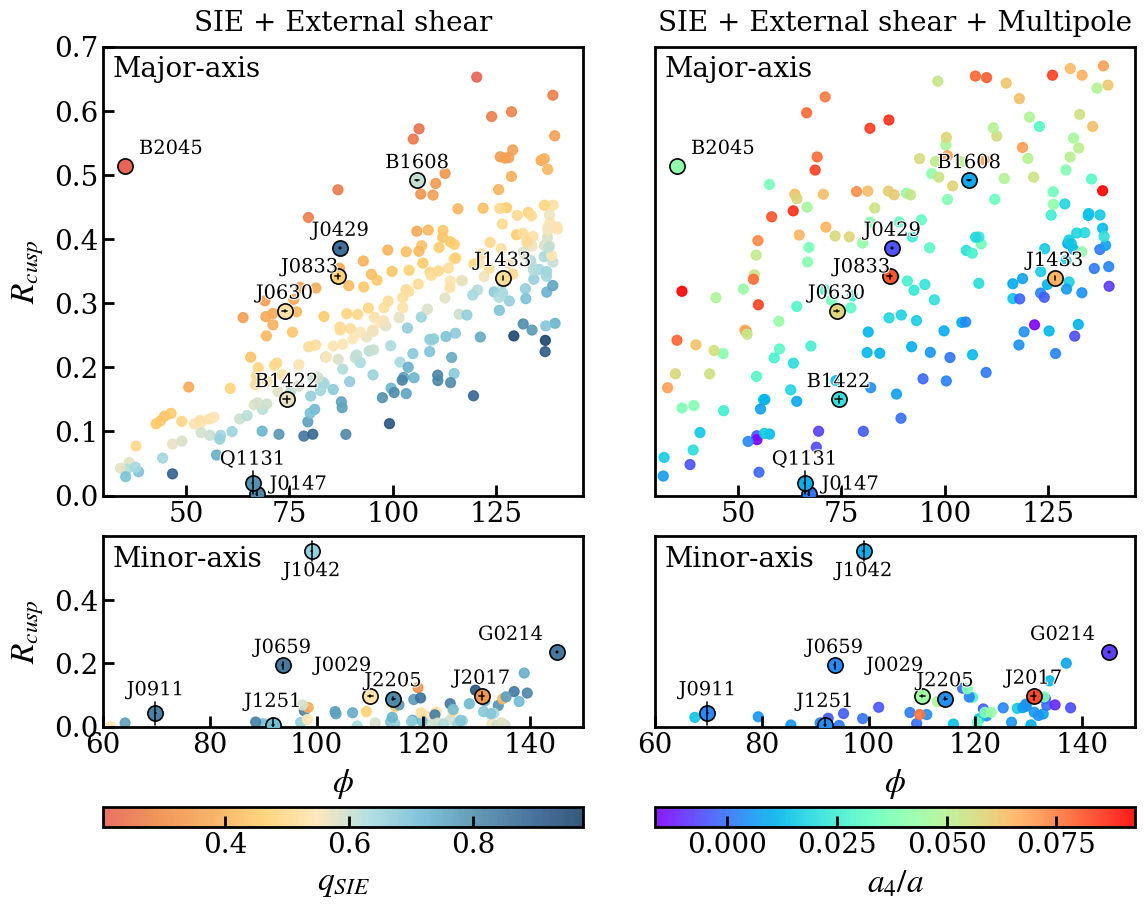

Saved: phi_Rcusp_q_a4_4panel.pdf


In [7]:
# =========================================================
# =========================================================
BASE_Q  = "Theory_Mock/all_sim"
BASE_A4 = "Theory_Mock/all_sim_Mul"
OUT = "phi_Rcusp_q_a4_4panel.pdf"
WRAP_PHI_TO_180 = True
PHI_MIN, PHI_MAX = 30, 146
RCUSP_MIN_LONG,  RCUSP_MAX_LONG  = 0.0, 0.7
RCUSP_MIN_SHORT, RCUSP_MAX_SHORT = 0.0, 0.6
PHI_MIN_MINOR, PHI_MAX_MINOR = 60, 150
LABEL_OFFSET_POINTS = {
    "Q1131": (0, 0),
    "J0147": (30, 0),
    "J0029": (-20,5),
    "J0833": (-20,0)
}
LABEL_ALIGN = {
    "Q1131": dict(ha="center", va="bottom"),
}
# =========================================================
# =========================================================
df_q  = load_params_generic(BASE_Q,  WRAP_PHI_TO_180, mode="q")
df_a4 = load_params_generic(BASE_A4, WRAP_PHI_TO_180, mode="a4")
fig = plt.figure(figsize=(12, 10))
notion_points, notion_n_major, notion_n_minor = get_notion_points()  # &&&!!!(2026-01-03 23:05)
print(f"[Notion obs] Major axis: {notion_n_major}, Minor axis: {notion_n_minor}")
# =========================================================
# =========================================================
notion_df = pd.DataFrame(notion_points)
cols = ["name", "axis", "phi", "phi_sigma", "rcusp", "rcusp_sigma", "q"]
notion_df = notion_df[cols].sort_values(["axis", "name"]).reset_index(drop=True)
pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)
print("\n========== [Notion points table] ==========")
print(notion_df.to_string(index=False))
notion_df.to_csv("notion_points_debug.csv", index=False)
print("\nSaved Notion table to: notion_points_debug.csv")
key_list = ["B2045", "2045", "b2045"]
hit = notion_df[notion_df["name"].astype(str).str.lower().isin([k.lower() for k in key_list])]
print("\n========== [Check B2045 / 2045] ==========")
if len(hit) == 0:
    print("Not found in notion_points (name mismatch?)")
else:
    print(hit.to_string(index=False))
bottom = 0.24
height = 0.68
axL1, axS1, cax1 = draw_two_rows(
    fig, left=0.07, bottom=bottom, width=0.40, height=height,
    df=df_q,
    label_var=r"$q_{SIE}$",
    reverse_cbar=False,
    remove_ylabel=False,
    notion_points=notion_points,
    notion_color_key="q",
    gap_frac=0.06,
    cbar_gap=0.08,
    cbar_height=0.020,
    phi_minor_min=PHI_MIN_MINOR,
    phi_minor_max=PHI_MAX_MINOR,
)
axL2, axS2, cax2 = draw_two_rows(
    fig, left=0.53, bottom=bottom, width=0.40, height=height,
    df=df_a4,
    label_var=r"$a_4/a$",
    cmap="rainbow",
    remove_ylabel=True,
    notion_points=notion_points,
    notion_color_key="a4_a",
    gap_frac=0.06,
    cbar_gap=0.08,
    cbar_height=0.020,
    phi_minor_min=PHI_MIN_MINOR,
    phi_minor_max=PHI_MAX_MINOR,
)
# =========================================================
# =========================================================
pos1 = axL1.get_position()
pos2 = axL2.get_position()
fig.text(pos1.x0 + pos1.width/2, pos1.y1 + 0.01,
         "SIE + External shear", ha="center", va="bottom")
fig.text(pos2.x0 + pos2.width/2, pos2.y1 + 0.01,
         "SIE + External shear + Multipole", ha="center", va="bottom")
# =========================================================
# =========================================================
fig.savefig(OUT, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", OUT)

# 2D plots

# Other parameter plots

In [2]:
from astropy.io import fits
file_path = "Theory_Mock/lensed_qso_mock_multipole.fits"
with fits.open(file_path) as hdul:
    # hdul.info()
    
    data = hdul[1].data
    
    print("Columns:", data.names)
    
    print("Total rows:", len(data))
    
    print("Preview:\n", data[:1])

Columns: ['idx', 'amp_shear', 'pa_shear', 'lambda_q', 'q_SIE', 'v_disp', 'lens_redshift', 'source_redshift', 'source_xlocation', 'source_ylocation', 'absolute_mag_i_band_ab', 'a3_over_a_signed', 'delta_phi_m3', 'a4_over_a_signed', 'delta_phi_m4', 'log_joint', 'images', 'image_sep', 'apparent_mag_first_arrival_i_band', 'image_number']
Total rows: 588856
Preview:
 [(0, 0.03683417, 195.53807394, 1.237, 0.89414101, 280.85859616, 0.03053137, 0.78012172, -1.57862001, -0.54274692, -15.93466567, 0.00322703, -0.06400635, 0.00511844, 0.12779892, 9.41143503, '[{"position": [-4.022781650683286, -1.6275194814331975], "kappa": 0.29647854014794345, "gamma1": 0.24465269029363806, "gamma2": -0.18708985494247082, "magnification": 2.499475407415513, "timedelay": -30.96373092225174, "apparent_mag_i_band": 26.567938149322547}, {"position": [0.006722178816343389, 0.0025115955468524996], "kappa": 184.79894471275642, "gamma1": 4.36765950846337, "gamma2": -17.541463036782073, "magnification": 4.365658309955017

In [18]:
def get_notion_zredshift_only():
    """
    Read zlens / zsource from Notion only
    Returns:
        points : list of dicts with name, zlens, zsource
    """
    names = get_all_lens_names(response) or []
    out = []
    for name in names:
        d = get_lens_data_by_name(response, name)
        if not isinstance(d, dict):
            continue
        try:
            zlens = float(d.get("zlens", np.nan))
            zsource = float(d.get("zsource", np.nan))
        except:
            continue
        if not (np.isfinite(zlens) and np.isfinite(zsource)):
            continue
        out.append({
            "name": name,
            "zlens": zlens,
            "zsource": zsource,
        })
    return out

# Tiled plots

## Parameter plots without selection effects

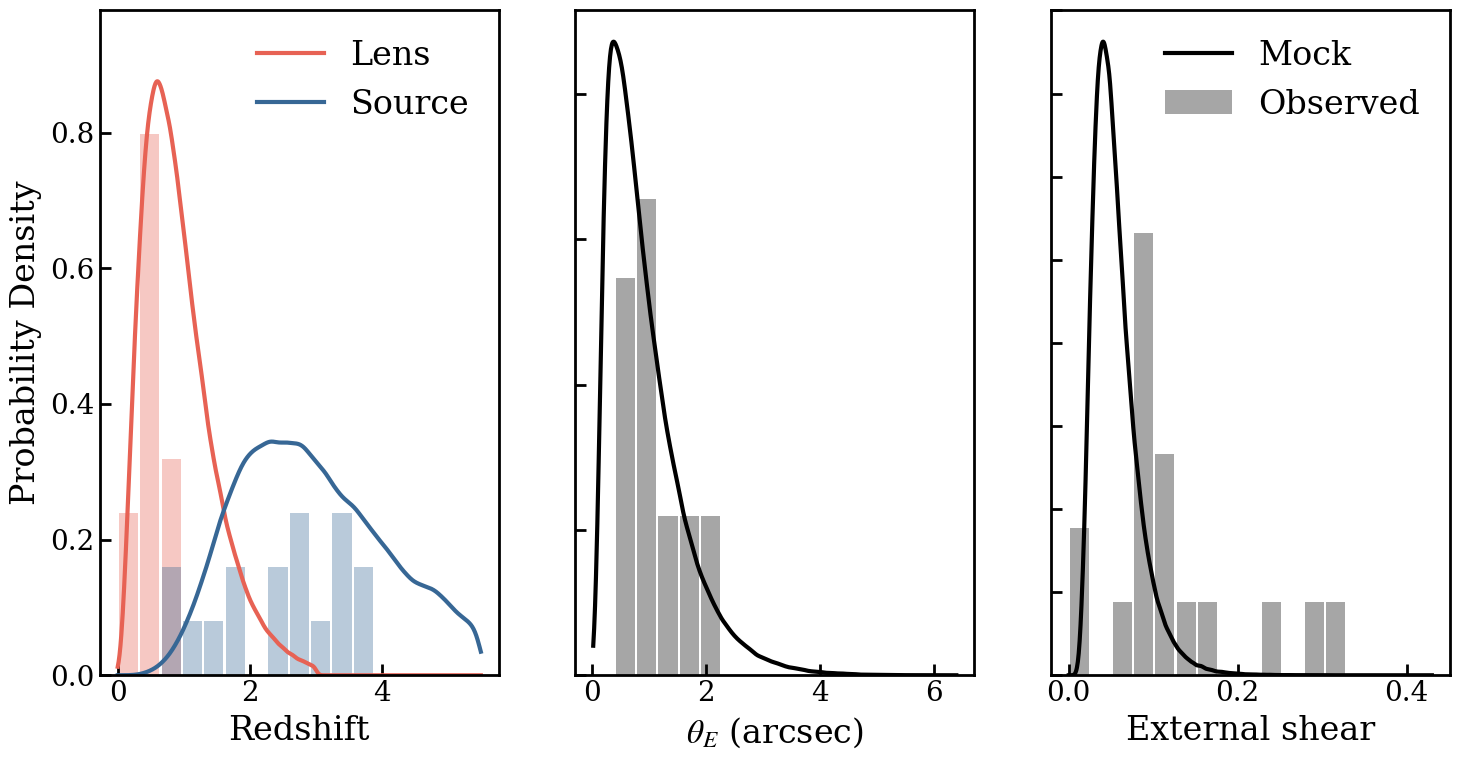

[INFO] Saved: population_summary.pdf
[INFO] N(zlens_obs)=17, N(zsrc_obs)=17
[INFO] N(theta_obs)=17, N(theta_mock)=588856
[INFO] N(gamma_obs)=17, N(gamma_mock)=588856


In [19]:
# ============================================================
# population_summary.py  (FULL, runnable)
# - 3 panels in one figure: redshift / theta_E / external shear
# - Right two panels: no y-label
# - Uses your existing logic (KDE + ground hist bars)
# ============================================================
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# -------------------------------
# You already have these in your env:
# - get_notion_zredshift_only()
# - notion: get_all_lens_names, get_lens_data_by_name
# - response (Notion API response handle)
# - colors (your palette list)
# -------------------------------
from notion import get_all_lens_names, get_lens_data_by_name
# ===============================
# 0) Notion helpers (theta, gamma)
# ===============================
def get_notion_theta_arcsec_only():
    names = get_all_lens_names(response) or []
    out = []
    for name in names:
        d = get_lens_data_by_name(response, name)
        if not isinstance(d, dict):
            continue
        try:
            th = float(d.get("theta_arcsec", np.nan))
        except Exception:
            th = np.nan
        if np.isfinite(th):
            out.append({"name": name, "theta_arcsec": th})
    return out
def get_notion_gamma_external_only():
    names = get_all_lens_names(response) or []
    out = []
    for name in names:
        d = get_lens_data_by_name(response, name)
        if not isinstance(d, dict):
            continue
        try:
            g = float(d.get("gamma_external", np.nan))
        except Exception:
            g = np.nan
        if np.isfinite(g):
            out.append({"name": name, "gamma_external": g})
    return out
# ==========================================================
# 1) Mock FITS (common)
# ==========================================================
file_path = "Theory_Mock/lensed_qso_mock_multipole.fits"
with fits.open(file_path) as hdul:
    data = hdul[1].data
    zlens = np.asarray(data["lens_redshift"], dtype=float)
    zsrc  = np.asarray(data["source_redshift"], dtype=float)
    gamma_mock = np.asarray(data["amp_shear"], dtype=float)
# Clean
zlens = zlens[np.isfinite(zlens)]
zsrc  = zsrc[np.isfinite(zsrc)]
gamma_mock = gamma_mock[np.isfinite(gamma_mock)]
gamma_mock = gamma_mock[gamma_mock >= 0]
# NOTE: theta_mock must exist in your environment.
# If your FITS has a theta_E column, you can uncomment below and set the column name.
# theta_mock = np.asarray(data["theta_E_arcsec"], dtype=float)
# theta_mock = theta_mock[np.isfinite(theta_mock)]
try:
    theta_mock
except NameError:
    raise NameError(
        "theta_mock is not defined.\n"
        "You used it in your original theta_E script but didn't include how it is computed.\n"
        "Please define theta_mock BEFORE running this script (same as your original notebook)."
    )
# ==========================================================
# 2) OBS from Notion
# ==========================================================
# ---- redshift obs ----
obs_points_z = get_notion_zredshift_only()
z_l_obs = np.array([p["zlens"] for p in obs_points_z], dtype=float)
z_s_obs = np.array([p["zsource"] for p in obs_points_z], dtype=float)
z_l_obs = z_l_obs[np.isfinite(z_l_obs)]
z_s_obs = z_s_obs[np.isfinite(z_s_obs)]
# ---- theta obs ----
obs_points_th = get_notion_theta_arcsec_only()
theta_obs = np.array([p["theta_arcsec"] for p in obs_points_th], dtype=float)
theta_obs = theta_obs[np.isfinite(theta_obs)]
# ---- gamma obs ----
obs_points_g = get_notion_gamma_external_only()
gamma_obs = np.array([p["gamma_external"] for p in obs_points_g], dtype=float)
gamma_obs = gamma_obs[np.isfinite(gamma_obs)]
gamma_obs = gamma_obs[gamma_obs >= 0]
# ==========================================================
# 3) Compute KDE + ground bars for each panel
# ==========================================================
# ----------------- (A) redshift -----------------
zmin = min(zlens.min(), zsrc.min())
zmax = max(zlens.max(), zsrc.max())
zgrid = np.linspace(zmin, zmax, 800)
pdf_lens = gaussian_kde(zlens)(zgrid)
pdf_src  = gaussian_kde(zsrc)(zgrid)
bins_obs_z = np.linspace(zmin, zmax, 18)
counts_l_z, _ = np.histogram(z_l_obs, bins=bins_obs_z, density=True)
counts_s_z, _ = np.histogram(z_s_obs, bins=bins_obs_z, density=True)
ymax_z = max(pdf_lens.max(), pdf_src.max())
scale_z = 0.50 * ymax_z
centers_z = 0.5 * (bins_obs_z[:-1] + bins_obs_z[1:])
width_z = bins_obs_z[1] - bins_obs_z[0]
# ----------------- (B) theta_E -----------------
xmin_th = min(theta_mock.min(), theta_obs.min()) if len(theta_obs) else theta_mock.min()
xmax_th = max(theta_mock.max(), theta_obs.max()) if len(theta_obs) else theta_mock.max()
xgrid_th = np.linspace(xmin_th, xmax_th, 800)
pdf_th = gaussian_kde(theta_mock)(xgrid_th)
# obs ground bars
if len(theta_obs) > 0:
    bins_obs_th = np.linspace(xmin_th, xmax_th, max(12, min(20, len(theta_obs) + 1)))
    counts_th, _ = np.histogram(theta_obs, bins=bins_obs_th, density=True)
    ymax_th = pdf_th.max()
    scale_th = 0.8 * ymax_th
    centers_th = 0.5 * (bins_obs_th[:-1] + bins_obs_th[1:])
    width_th = bins_obs_th[1] - bins_obs_th[0]
else:
    counts_th = None
    centers_th = None
    width_th = None
    ymax_th = pdf_th.max()
    scale_th = None
# ----------------- (C) gamma_external -----------------
xmin_g = min(gamma_mock.min(), gamma_obs.min()) if len(gamma_obs) else gamma_mock.min()
xmax_g = max(gamma_mock.max(), gamma_obs.max()) if len(gamma_obs) else gamma_mock.max()
xgrid_g = np.linspace(xmin_g, xmax_g, 800)
pdf_g = gaussian_kde(gamma_mock)(xgrid_g)
if len(gamma_obs) > 0:
    bins_obs_g = np.linspace(xmin_g, xmax_g, max(12, min(20, len(gamma_obs) + 1)))
    counts_g, _ = np.histogram(gamma_obs, bins=bins_obs_g, density=True)
    ymax_g = pdf_g.max()
    scale_g = 0.05 * ymax_g
    centers_g = 0.5 * (bins_obs_g[:-1] + bins_obs_g[1:])
    width_g = bins_obs_g[1] - bins_obs_g[0]
else:
    counts_g = None
    centers_g = None
    width_g = None
    ymax_g = pdf_g.max()
    scale_g = None
# ==========================================================
# 4) Plot: 1x3 panels
# ==========================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 8.0))
ax_z, ax_th, ax_g = axes
# colors
try:
    color_zlens   = colors[0]
    color_zsource = colors[-2]
except Exception:
    # fallback
    color_zlens   = "tab:red"
    color_zsource = "tab:blue"
# -------- Panel 1: redshift --------
ax_z.plot(zgrid, pdf_lens, lw=3, color=color_zlens,   label=r"Lens")
ax_z.plot(zgrid, pdf_src,  lw=3, color=color_zsource, label=r"Source")
ax_z.bar(
    centers_z, counts_l_z * scale_z,
    width=0.9 * width_z,
    bottom=0.0,
    color=color_zlens,
    alpha=0.35,
    edgecolor="none",
    label="_nolegend_"
)
ax_z.bar(
    centers_z, counts_s_z * scale_z,
    width=0.9 * width_z,
    bottom=0.0,
    color=color_zsource,
    alpha=0.35,
    edgecolor="none",
    label="_nolegend_"
)
ax_z.set_xlabel("Redshift")
ax_z.set_ylabel("Probability Density")
ax_z.set_ylim(0, 1.12 * ymax_z)
ax_z.legend(frameon=False, fontsize=24)
# -------- Panel 2: theta_E --------
ax_th.plot(xgrid_th, pdf_th, lw=3, color="k")
if len(theta_obs) > 0:
    ax_th.bar(
        centers_th, counts_th * scale_th,
        width=0.9 * width_th,
        bottom=0.0,
        color="k",
        alpha=0.35,
        edgecolor="none",
        label="_nolegend_"
    )
ax_th.set_xlabel(r"$\theta_E$ (arcsec)")
ax_th.set_ylabel("")                # 👈 no y-label
ax_th.tick_params(labelleft=False)  # 👈 no y tick labels
# -------- Panel 3: external shear --------
ax_g.plot(xgrid_g, pdf_g, lw=3, color="k")
if len(gamma_obs) > 0:
    ax_g.bar(
        centers_g, counts_g * scale_g,
        width=0.9 * width_g,
        bottom=0.0,
        color="k",
        alpha=0.35,
        edgecolor="none",
        label="_nolegend_"
    )
ax_g.set_xlabel("External shear")
ax_g.set_ylabel("")                # 👈 no y-label
ax_g.tick_params(labelleft=False)  # 👈 no y tick labels
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
    Line2D([0], [0], color="k", lw=3, label="Mock"),
    Patch(facecolor="k", alpha=0.35, label="Observed"),
]
ax_g.legend(
    handles=legend_elements,
    loc="upper right",
    frameon=False,
    fontsize=24
)
plt.tight_layout(w_pad=2.5)
plt.savefig("population_summary.pdf", bbox_inches="tight")
plt.show()
print("[INFO] Saved: population_summary.pdf")
print(f"[INFO] N(zlens_obs)={len(z_l_obs)}, N(zsrc_obs)={len(z_s_obs)}")
print(f"[INFO] N(theta_obs)={len(theta_obs)}, N(theta_mock)={len(theta_mock)}")
print(f"[INFO] N(gamma_obs)={len(gamma_obs)}, N(gamma_mock)={len(gamma_mock)}")

### Apply selection

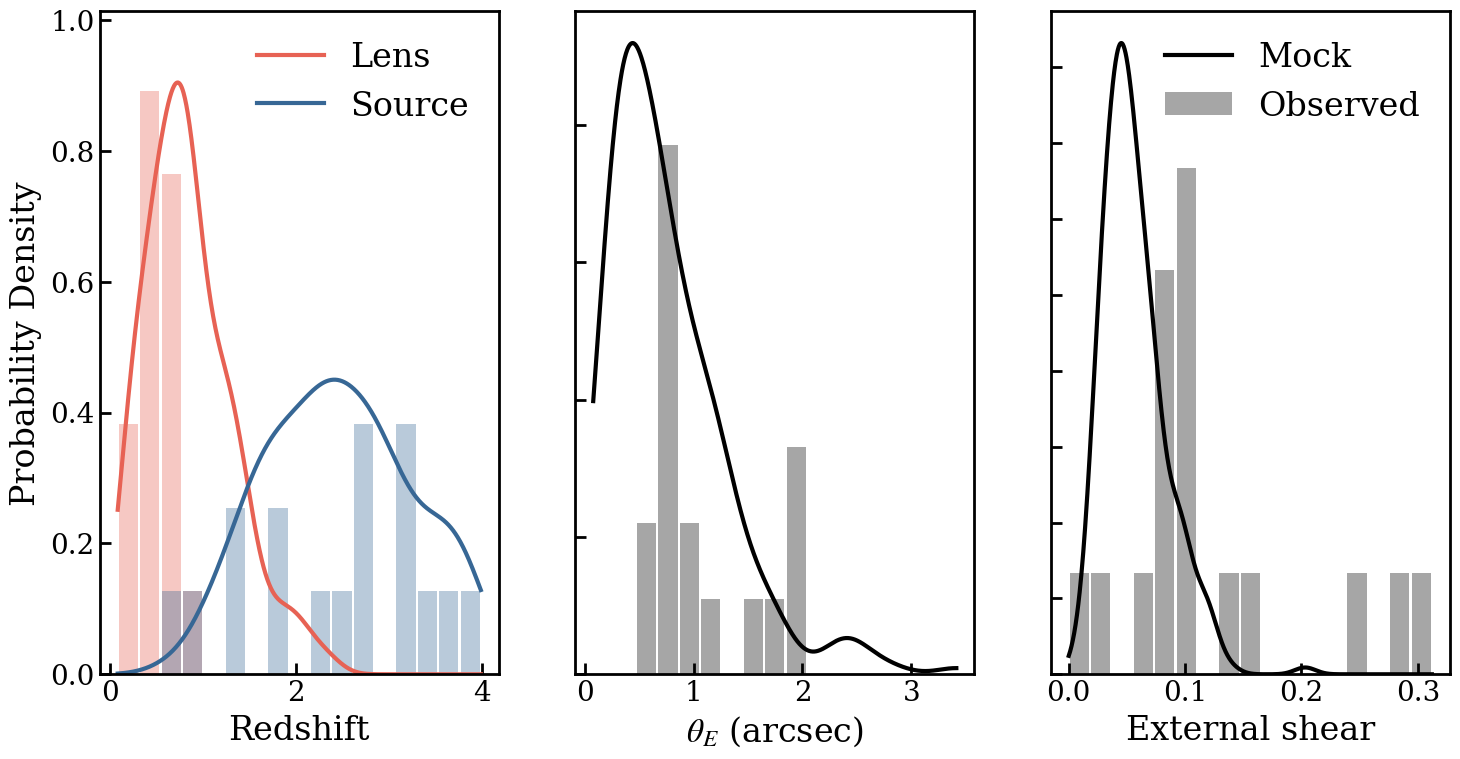

[INFO] Saved: population_summary.pdf
[INFO] N(zlens_obs)=17, N(zsrc_obs)=17
[INFO] N(theta_obs)=17, N(theta_mock)=248
[INFO] N(gamma_obs)=17, N(gamma_mock)=248


In [37]:
# ==========================================================
# 1) Mock from load_params()  (replace your FITS block)
# ==========================================================
# Assumes you already have load_params() defined/imported.
# e.g., from your_module import load_params
df = load_params("Theory_Mock/all_sim_Mul")
if df.empty:
    raise RuntimeError("load_params() returned an empty DataFrame.")
# ---- redshift (mock) ----
zlens = df["zlens"].to_numpy(dtype=float)
zsrc  = df["zsource"].to_numpy(dtype=float)
zlens = zlens[np.isfinite(zlens)]
zsrc  = zsrc[np.isfinite(zsrc)]
# ---- theta_E (mock) ----
# This replaces the old "theta_mock must exist in your environment" requirement.
theta_mock = df["thetaE"].to_numpy(dtype=float)
theta_mock = theta_mock[np.isfinite(theta_mock)]
if theta_mock.size == 0:
    raise RuntimeError("theta_mock is empty: column 'thetaE' is missing or all NaN in df.")
# ---- external shear (mock) ----
# Requires you added/standardized 'gamma_external' in load_params().
gamma_mock = df["gamma_external"].to_numpy(dtype=float)
gamma_mock = gamma_mock[np.isfinite(gamma_mock)]
gamma_mock = gamma_mock[gamma_mock >= 0]
if gamma_mock.size == 0:
    raise RuntimeError("gamma_mock is empty: column 'gamma_external' is missing or all NaN in df.")
# ==========================================================
# 2) OBS from Notion
# ==========================================================
# ---- redshift obs ----
obs_points_z = get_notion_zredshift_only()
z_l_obs = np.array([p["zlens"] for p in obs_points_z], dtype=float)
z_s_obs = np.array([p["zsource"] for p in obs_points_z], dtype=float)
z_l_obs = z_l_obs[np.isfinite(z_l_obs)]
z_s_obs = z_s_obs[np.isfinite(z_s_obs)]
# ---- theta obs ----
obs_points_th = get_notion_theta_arcsec_only()
theta_obs = np.array([p["theta_arcsec"] for p in obs_points_th], dtype=float)
theta_obs = theta_obs[np.isfinite(theta_obs)]
# ---- gamma obs ----
obs_points_g = get_notion_gamma_external_only()
gamma_obs = np.array([p["gamma_external"] for p in obs_points_g], dtype=float)
gamma_obs = gamma_obs[np.isfinite(gamma_obs)]
gamma_obs = gamma_obs[gamma_obs >= 0]
# ==========================================================
# 3) Compute KDE + ground bars for each panel
# ==========================================================
# ----------------- (A) redshift -----------------
zmin = min(zlens.min(), zsrc.min())
zmax = max(zlens.max(), zsrc.max())
zgrid = np.linspace(zmin, zmax, 800)
pdf_lens = gaussian_kde(zlens)(zgrid)
pdf_src  = gaussian_kde(zsrc)(zgrid)
bins_obs_z = np.linspace(zmin, zmax, 18)
counts_l_z, _ = np.histogram(z_l_obs, bins=bins_obs_z, density=True)
counts_s_z, _ = np.histogram(z_s_obs, bins=bins_obs_z, density=True)
ymax_z = max(pdf_lens.max(), pdf_src.max())
scale_z = 0.55 * ymax_z
centers_z = 0.5 * (bins_obs_z[:-1] + bins_obs_z[1:])
width_z = bins_obs_z[1] - bins_obs_z[0]
# ----------------- (B) theta_E -----------------
xmin_th = min(theta_mock.min(), theta_obs.min()) if len(theta_obs) else theta_mock.min()
xmax_th = max(theta_mock.max(), theta_obs.max()) if len(theta_obs) else theta_mock.max()
xgrid_th = np.linspace(xmin_th, xmax_th, 800)
pdf_th = gaussian_kde(theta_mock)(xgrid_th)
# obs ground bars
if len(theta_obs) > 0:
    bins_obs_th = np.linspace(xmin_th, xmax_th, max(12, min(20, len(theta_obs) + 1)))
    counts_th, _ = np.histogram(theta_obs, bins=bins_obs_th, density=True)
    ymax_th = pdf_th.max()
    scale_th = 0.4 * ymax_th
    centers_th = 0.5 * (bins_obs_th[:-1] + bins_obs_th[1:])
    width_th = bins_obs_th[1] - bins_obs_th[0]
else:
    counts_th = None
    centers_th = None
    width_th = None
    ymax_th = pdf_th.max()
    scale_th = None
# ----------------- (C) gamma_external -----------------
xmin_g = min(gamma_mock.min(), gamma_obs.min()) if len(gamma_obs) else gamma_mock.min()
xmax_g = max(gamma_mock.max(), gamma_obs.max()) if len(gamma_obs) else gamma_mock.max()
xgrid_g = np.linspace(xmin_g, xmax_g, 800)
pdf_g = gaussian_kde(gamma_mock)(xgrid_g)
if len(gamma_obs) > 0:
    bins_obs_g = np.linspace(xmin_g, xmax_g, max(12, min(20, len(gamma_obs) + 1)))
    counts_g, _ = np.histogram(gamma_obs, bins=bins_obs_g, density=True)
    ymax_g = pdf_g.max()
    scale_g = 0.05 * ymax_g
    centers_g = 0.5 * (bins_obs_g[:-1] + bins_obs_g[1:])
    width_g = bins_obs_g[1] - bins_obs_g[0]
else:
    counts_g = None
    centers_g = None
    width_g = None
    ymax_g = pdf_g.max()
    scale_g = None
# ==========================================================
# 4) Plot: 1x3 panels
# ==========================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 8.0))
ax_z, ax_th, ax_g = axes
# colors
try:
    color_zlens   = colors[0]
    color_zsource = colors[-2]
except Exception:
    # fallback
    color_zlens   = "tab:red"
    color_zsource = "tab:blue"
# -------- Panel 1: redshift --------
ax_z.plot(zgrid, pdf_lens, lw=3, color=color_zlens,   label=r"Lens")
ax_z.plot(zgrid, pdf_src,  lw=3, color=color_zsource, label=r"Source")
ax_z.bar(
    centers_z, counts_l_z * scale_z,
    width=0.9 * width_z,
    bottom=0.0,
    color=color_zlens,
    alpha=0.35,
    edgecolor="none",
    label="_nolegend_"
)
ax_z.bar(
    centers_z, counts_s_z * scale_z,
    width=0.9 * width_z,
    bottom=0.0,
    color=color_zsource,
    alpha=0.35,
    edgecolor="none",
    label="_nolegend_"
)
ax_z.set_xlabel("Redshift")
ax_z.set_ylabel("Probability Density")
ax_z.set_ylim(0, 1.12 * ymax_z)
ax_z.legend(frameon=False, fontsize=24)
# -------- Panel 2: theta_E --------
ax_th.plot(xgrid_th, pdf_th, lw=3, color="k")
if len(theta_obs) > 0:
    ax_th.bar(
        centers_th, counts_th * scale_th,
        width=0.9 * width_th,
        bottom=0.0,
        color="k",
        alpha=0.35,
        edgecolor="none",
        label="_nolegend_"
    )
ax_th.set_xlabel(r"$\theta_E$ (arcsec)")
ax_th.set_ylabel("")                # 👈 no y-label
ax_th.tick_params(labelleft=False)  # 👈 no y tick labels
# -------- Panel 3: external shear --------
ax_g.plot(xgrid_g, pdf_g, lw=3, color="k")
if len(gamma_obs) > 0:
    ax_g.bar(
        centers_g, counts_g * scale_g,
        width=0.9 * width_g,
        bottom=0.0,
        color="k",
        alpha=0.35,
        edgecolor="none",
        label="_nolegend_"
    )
ax_g.set_xlabel("External shear")
ax_g.set_ylabel("")                # 👈 no y-label
ax_g.tick_params(labelleft=False)  # 👈 no y tick labels
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
    Line2D([0], [0], color="k", lw=3, label="Mock"),
    Patch(facecolor="k", alpha=0.35, label="Observed"),
]
ax_g.legend(
    handles=legend_elements,
    loc="upper right",
    frameon=False,
    fontsize=24
)
plt.tight_layout(w_pad=2.5)
plt.savefig("population_summary.pdf", bbox_inches="tight")
plt.show()
print("[INFO] Saved: population_summary.pdf")
print(f"[INFO] N(zlens_obs)={len(z_l_obs)}, N(zsrc_obs)={len(z_s_obs)}")
print(f"[INFO] N(theta_obs)={len(theta_obs)}, N(theta_mock)={len(theta_mock)}")
print(f"[INFO] N(gamma_obs)={len(gamma_obs)}, N(gamma_mock)={len(gamma_mock)}")

## Multipole plots

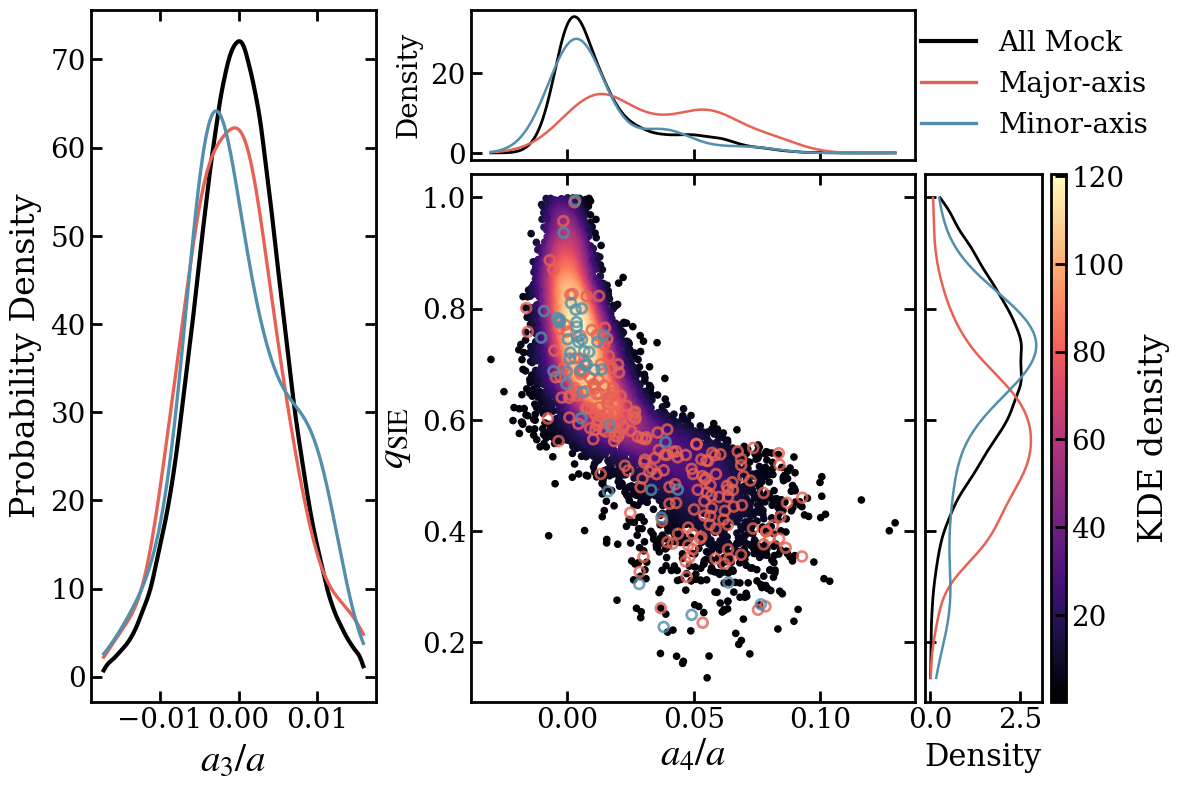

✅ Saved: a3_left_a4q_right.pdf


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import gaussian_kde
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
file_path = "Theory_Mock/lensed_qso_mock_multipole.fits"
def make_combined_a3_left_a4q_right(file_path, save_path="a3_left_a4q_right.pdf"):
    # =========================
    # =========================
    with fits.open(file_path) as hdul:
        data = hdul[1].data
        a4_all = np.asarray(data["a4_over_a_signed"], dtype=float)
        q_all  = np.asarray(data["q_SIE"], dtype=float)
        a3_all = np.asarray(data["a3_over_a_signed"], dtype=float)
    m = np.isfinite(a4_all) & np.isfinite(q_all)
    a4_all, q_all = a4_all[m], q_all[m]
    a3_all = a3_all[np.isfinite(a3_all)]
    max_points = 10000
    n_total = len(q_all)
    if n_total > max_points:
        idx_sample = np.random.choice(n_total, size=max_points, replace=False)
        a4_sample = a4_all[idx_sample]
        q_sample  = q_all[idx_sample]
    else:
        a4_sample = a4_all
        q_sample  = q_all
    # 2D KDE density
    xy = np.vstack([a4_sample, q_sample])
    kde2d = gaussian_kde(xy)
    z = kde2d(xy)
    sort_idx = np.argsort(z)
    a4_sorted = a4_sample[sort_idx]
    q_sorted  = q_sample[sort_idx]
    z_sorted  = z[sort_idx]
    # =========================
    # =========================
    df2 = load_params("Theory_Mock/all_sim_Mul")
    dfL = df2[df2.axis_type == "long_axis"]    # Major-axis
    dfS = df2[df2.axis_type == "short_axis"]   # Minor-axis
    a4_L = dfL["a4_over_a_signed"].values.astype(float)
    q_L  = dfL["q"].values.astype(float)
    a3_L = dfL["a3_over_a_signed"].values.astype(float)
    a4_S = dfS["a4_over_a_signed"].values.astype(float)
    q_S  = dfS["q"].values.astype(float)
    a3_S = dfS["a3_over_a_signed"].values.astype(float)
    mL = np.isfinite(a4_L) & np.isfinite(q_L)
    a4_L, q_L = a4_L[mL], q_L[mL]
    a3_L = a3_L[np.isfinite(a3_L)]
    mS = np.isfinite(a4_S) & np.isfinite(q_S)
    a4_S, q_S = a4_S[mS], q_S[mS]
    a3_S = a3_S[np.isfinite(a3_S)]
    # =========================
    # =========================
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(
        6, 10, figure=fig,
        height_ratios=[0.9, 1.0, 1.0, 1.0, 0.25, 0.05],
        width_ratios=[
            1.00,
            0.85,
            0.5,
            0.95,
            0.95,
            0.95,
            0.78,
            0.10,  # [7] colorbar
            0.55,
            0.05   # [9] padding
        ],
        wspace=0.10,
        hspace=0.12
    )
    ax_a3 = fig.add_subplot(gs[0:4, 0:2])
    ax_main  = fig.add_subplot(gs[1:4, 3:6])
    ax_top   = fig.add_subplot(gs[0,   3:6], sharex=ax_main)
    ax_right = fig.add_subplot(gs[1:4, 6],   sharey=ax_main)
    cax      = fig.add_subplot(gs[1:4, 7])
    ax_spacer = fig.add_subplot(gs[4, 3:6])
    ax_spacer.axis("off")
    # =========================
    # =========================
    sc = ax_main.scatter(
        a4_sorted, q_sorted,
        c=z_sorted, s=20,
        cmap="magma",
        rasterized=True
    )
    color_major = colors[0]
    color_minor = colors[-3]
    ax_main.scatter(
        a4_L, q_L,
        s=50, facecolor="none", edgecolor=color_major,
        linewidth=2, alpha=0.8
    )
    ax_main.scatter(
        a4_S, q_S,
        s=50, facecolor="none", edgecolor=color_minor,
        linewidth=2, alpha=0.8
    )
    ax_main.set_xlabel(r"$a_4/a$", fontsize=28, labelpad=2)
    ax_main.set_ylabel(r"$q_{\rm SIE}$", fontsize=28)
    ax_main.tick_params(direction="in", top=True, right=True)
    ax_main.spines["top"].set_visible(True)
    ax_main.spines["right"].set_visible(True)
    cbar = fig.colorbar(sc, cax=cax, orientation="vertical")
    cbar.set_label("KDE density", fontsize=24, rotation=90, labelpad=10)
    cbar.ax.tick_params(labelsize=20, direction="in")
    x_vals = np.linspace(np.nanmin(a4_sample), np.nanmax(a4_sample), 800)
    ax_top.plot(x_vals, gaussian_kde(a4_sample)(x_vals), color="k", lw=2)
    if len(a4_L) > 2:
        ax_top.plot(x_vals, gaussian_kde(a4_L)(x_vals), color=color_major, lw=1.8)
    if len(a4_S) > 2:
        ax_top.plot(x_vals, gaussian_kde(a4_S)(x_vals), color=color_minor, lw=1.8)
    ax_top.tick_params(labelbottom=False, direction="in")
    ax_top.set_ylabel("Density", fontsize=20)
    ax_top.spines["top"].set_visible(True)
    ax_top.spines["right"].set_visible(True)
    y_vals = np.linspace(np.nanmin(q_sample), np.nanmax(q_sample), 800)
    ax_right.plot(gaussian_kde(q_sample)(y_vals), y_vals, color="k", lw=2)
    if len(q_L) > 2:
        ax_right.plot(gaussian_kde(q_L)(y_vals), y_vals, color=color_major, lw=1.8)
    if len(q_S) > 2:
        ax_right.plot(gaussian_kde(q_S)(y_vals), y_vals, color=color_minor, lw=1.8)
    ax_right.tick_params(labelleft=False, direction="in")
    ax_right.set_xlabel("Density", fontsize=22)
    ax_right.spines["top"].set_visible(True)
    ax_right.spines["right"].set_visible(True)
    # =========================
    # =========================
    def qclip(arr, lo=0.5, hi=99.5):
        arr = np.asarray(arr)
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            return None, None
        return np.percentile(arr, lo), np.percentile(arr, hi)
    lo_all, hi_all = qclip(a3_all, 0.5, 99.5)
    lo_L,   hi_L   = qclip(a3_L,   0.5, 99.5)
    lo_S,   hi_S   = qclip(a3_S,   0.5, 99.5)
    lo = np.nanmin([lo_all, lo_L, lo_S])
    hi = np.nanmax([hi_all, hi_L, hi_S])
    xgrid = np.linspace(lo, hi, 800)
    a3_all_use = a3_all[(a3_all >= lo) & (a3_all <= hi)]
    pdf_all = gaussian_kde(a3_all_use)(xgrid) if a3_all_use.size > 10 else np.zeros_like(xgrid)
    a3_L_use = a3_L[(a3_L >= lo) & (a3_L <= hi)]
    a3_S_use = a3_S[(a3_S >= lo) & (a3_S <= hi)]
    pdf_L = gaussian_kde(a3_L_use)(xgrid) if a3_L_use.size > 10 else np.zeros_like(xgrid)
    pdf_S = gaussian_kde(a3_S_use)(xgrid) if a3_S_use.size > 10 else np.zeros_like(xgrid)
    ax_a3.plot(xgrid, pdf_all, lw=3, color="k")
    ax_a3.plot(xgrid, pdf_L,   lw=2.4, color=color_major)
    ax_a3.plot(xgrid, pdf_S,   lw=2.4, color=color_minor)
    ax_a3.set_xlabel(r"$a_3/a$", fontsize=28)
    ax_a3.set_ylabel("Probability Density", fontsize=24)
    ax_a3.tick_params(direction="in", top=True, right=True)
    ax_a3.spines["top"].set_visible(True)
    ax_a3.spines["right"].set_visible(True)
    # =========================
    # =========================
    legend_handles = [
        Line2D([0], [0], color="k", lw=3, label="All Mock"),
        Line2D([0], [0], color=color_major, lw=2.4, label="Major-axis"),
        Line2D([0], [0], color=color_minor, lw=2.4, label="Minor-axis"),
    ]
    fig.legend(
        handles=legend_handles,
        loc="upper left",
        bbox_to_anchor=(0.70, 0.885),
        frameon=False,
        fontsize=20
    )
    # =========================
    # =========================
    fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()
    print(f"OK Saved: {save_path}")
make_combined_a3_left_a4q_right(file_path, save_path="a3_left_a4q_right.pdf")

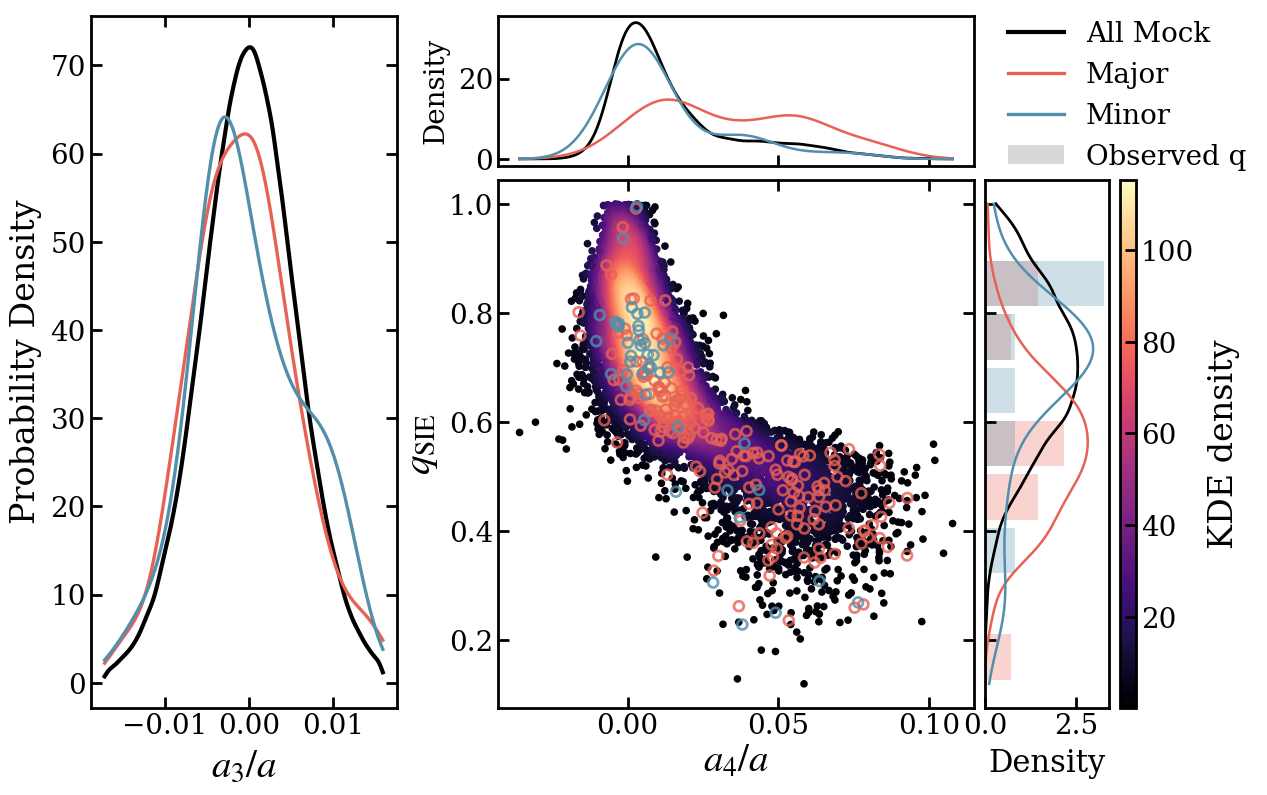

✅ Saved: a3_left_a4q_right.pdf
[INFO] N(q_obs_major)=9, N(q_obs_minor)=8


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import gaussian_kde
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
file_path = "Theory_Mock/lensed_qso_mock_multipole.fits"
# Assumes you already have these in your env:
# - load_params()
# - colors
# - response
# - from notion import get_all_lens_names, get_lens_data_by_name
from notion import get_all_lens_names, get_lens_data_by_name
def get_notion_q_by_axis_type():
    """
    OBS q from Notion, split by axis_type.
    Expected fields (try in order):
      - q: 'q_SIE', 'q', 'q_sie', 'q_sie_obs'
      - axis: 'axis_type', 'axis', 'cusp_axis', 'cusp_type'
    Accepts values like:
      - 'long_axis' / 'short_axis'
      - 'major' / 'minor'
      - 'Major-axis' / 'Minor-axis'
    """
    def _parse_q(d):
        for k in ("q_SIE", "q", "q_sie", "q_sie_obs"):
            try:
                v = float(d.get(k, np.nan))
            except Exception:
                v = np.nan
            if np.isfinite(v):
                return v
        return np.nan
    def _parse_axis(d):
        for k in ("axis_type", "axis", "cusp_axis", "cusp_type"):
            v = d.get(k, None)
            if v is None:
                continue
            s = str(v).strip().lower()
            if s in ("long_axis", "major", "major-axis", "major_axis", "long"):
                return "long_axis"
            if s in ("short_axis", "minor", "minor-axis", "minor_axis", "short"):
                return "short_axis"
        return None
    names = get_all_lens_names(response) or []
    outL, outS = [], []
    for name in names:
        d = get_lens_data_by_name(response, name)
        if not isinstance(d, dict):
            continue
        q = _parse_q(d)
        axis = _parse_axis(d)
        if not (np.isfinite(q) and (0 < q <= 1.0)):
            continue
        if axis == "long_axis":
            outL.append({"name": name, "q_obs": q})
        elif axis == "short_axis":
            outS.append({"name": name, "q_obs": q})
        # axis missing -> ignore (or you can collect into a separate list if you want)
    return outL, outS
def make_combined_a3_left_a4q_right(file_path, save_path="a3_left_a4q_right.pdf"):
    # =========================
    # =========================
    with fits.open(file_path) as hdul:
        data = hdul[1].data
        a4_all = np.asarray(data["a4_over_a_signed"], dtype=float)
        q_all  = np.asarray(data["q_SIE"], dtype=float)
        a3_all = np.asarray(data["a3_over_a_signed"], dtype=float)
    m = np.isfinite(a4_all) & np.isfinite(q_all)
    a4_all, q_all = a4_all[m], q_all[m]
    a3_all = a3_all[np.isfinite(a3_all)]
    max_points = 10000
    n_total = len(q_all)
    if n_total > max_points:
        idx_sample = np.random.choice(n_total, size=max_points, replace=False)
        a4_sample = a4_all[idx_sample]
        q_sample  = q_all[idx_sample]
    else:
        a4_sample = a4_all
        q_sample  = q_all
    # 2D KDE density
    xy = np.vstack([a4_sample, q_sample])
    kde2d = gaussian_kde(xy)
    z = kde2d(xy)
    sort_idx = np.argsort(z)
    a4_sorted = a4_sample[sort_idx]
    q_sorted  = q_sample[sort_idx]
    z_sorted  = z[sort_idx]
    # =========================
    # =========================
    df2 = load_params("Theory_Mock/all_sim_Mul")
    dfL = df2[df2.axis_type == "long_axis"]    # Major-axis
    dfS = df2[df2.axis_type == "short_axis"]   # Minor-axis
    a4_L = dfL["a4_over_a_signed"].values.astype(float)
    q_L  = dfL["q"].values.astype(float)
    a3_L = dfL["a3_over_a_signed"].values.astype(float)
    a4_S = dfS["a4_over_a_signed"].values.astype(float)
    q_S  = dfS["q"].values.astype(float)
    a3_S = dfS["a3_over_a_signed"].values.astype(float)
    mL = np.isfinite(a4_L) & np.isfinite(q_L)
    a4_L, q_L = a4_L[mL], q_L[mL]
    a3_L = a3_L[np.isfinite(a3_L)]
    mS = np.isfinite(a4_S) & np.isfinite(q_S)
    a4_S, q_S = a4_S[mS], q_S[mS]
    a3_S = a3_S[np.isfinite(a3_S)]
    # =========================
    # B2) OBS q from Notion: split by axis_type
    # =========================
    obs_q_L_pts, obs_q_S_pts = get_notion_q_by_axis_type()
    q_obs_L = np.array([p["q_obs"] for p in obs_q_L_pts], dtype=float)
    q_obs_S = np.array([p["q_obs"] for p in obs_q_S_pts], dtype=float)
    q_obs_L = q_obs_L[np.isfinite(q_obs_L)]
    q_obs_S = q_obs_S[np.isfinite(q_obs_S)]
    # =========================
    # C) Layout
    # =========================
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(
        6, 10, figure=fig,
        height_ratios=[0.9, 1.0, 1.0, 1.0, 0.25, 0.05],
        width_ratios=[1.00, 0.85, 0.5, 0.95, 0.95, 0.95, 0.78, 0.10, 0.55, 0.05],
        wspace=0.10,
        hspace=0.12
    )
    ax_a3 = fig.add_subplot(gs[0:4, 0:2])
    ax_main  = fig.add_subplot(gs[1:4, 3:6])
    ax_top   = fig.add_subplot(gs[0,   3:6], sharex=ax_main)
    ax_right = fig.add_subplot(gs[1:4, 6],   sharey=ax_main)
    cax      = fig.add_subplot(gs[1:4, 7])
    ax_spacer = fig.add_subplot(gs[4, 3:6])
    ax_spacer.axis("off")
    # =========================
    # =========================
    sc = ax_main.scatter(
        a4_sorted, q_sorted,
        c=z_sorted, s=20,
        cmap="magma",
        rasterized=True
    )
    color_major = colors[0]
    color_minor = colors[-3]
    ax_main.scatter(a4_L, q_L, s=50, facecolor="none", edgecolor=color_major, linewidth=2, alpha=0.8)
    ax_main.scatter(a4_S, q_S, s=50, facecolor="none", edgecolor=color_minor, linewidth=2, alpha=0.8)
    ax_main.set_xlabel(r"$a_4/a$", fontsize=28, labelpad=2)
    ax_main.set_ylabel(r"$q_{\rm SIE}$", fontsize=28)
    ax_main.tick_params(direction="in", top=True, right=True)
    ax_main.spines["top"].set_visible(True)
    ax_main.spines["right"].set_visible(True)
    cbar = fig.colorbar(sc, cax=cax, orientation="vertical")
    cbar.set_label("KDE density", fontsize=24, rotation=90, labelpad=10)
    cbar.ax.tick_params(labelsize=20, direction="in")
    x_vals = np.linspace(np.nanmin(a4_sample), np.nanmax(a4_sample), 800)
    ax_top.plot(x_vals, gaussian_kde(a4_sample)(x_vals), color="k", lw=2)
    if len(a4_L) > 2:
        ax_top.plot(x_vals, gaussian_kde(a4_L)(x_vals), color=color_major, lw=1.8)
    if len(a4_S) > 2:
        ax_top.plot(x_vals, gaussian_kde(a4_S)(x_vals), color=color_minor, lw=1.8)
    ax_top.tick_params(labelbottom=False, direction="in")
    ax_top.set_ylabel("Density", fontsize=20)
    ax_top.spines["top"].set_visible(True)
    ax_top.spines["right"].set_visible(True)
    y_vals = np.linspace(np.nanmin(q_sample), np.nanmax(q_sample), 800)
    pdf_q_all = gaussian_kde(q_sample)(y_vals)
    ax_right.plot(pdf_q_all, y_vals, color="k", lw=2)
    if len(q_L) > 2:
        ax_right.plot(gaussian_kde(q_L)(y_vals), y_vals, color=color_major, lw=1.8)
    if len(q_S) > 2:
        ax_right.plot(gaussian_kde(q_S)(y_vals), y_vals, color=color_minor, lw=1.8)
    # ---- OBS q as ground bars (split major/minor, using your colors) ----
    def _barh_obs_q(q_obs, color, alpha=0.30):
        if q_obs.size == 0:
            return
        qmin = np.nanmin([np.nanmin(q_sample), np.nanmin(q_obs)])
        qmax = np.nanmax([np.nanmax(q_sample), np.nanmax(q_obs)])
        bins_q = np.linspace(qmin, qmax, max(10, min(18, q_obs.size + 1)))
        counts_q, edges_q = np.histogram(q_obs, bins=bins_q, density=True)
        centers_q = 0.5 * (edges_q[:-1] + edges_q[1:])
        height_q = 0.85 * (edges_q[1] - edges_q[0])
        # scale: keep as "ground bars" relative to mock KDE peak
        scale_q = 0.25 * np.nanmax(pdf_q_all)
        ax_right.barh(
            centers_q,
            counts_q * scale_q,
            height=height_q,
            left=0.0,
            color=color,
            alpha=alpha,
            edgecolor="none",
            zorder=0
        )
    _barh_obs_q(q_obs_L, color_major, alpha=0.28)
    _barh_obs_q(q_obs_S, color_minor, alpha=0.28)
    ax_right.tick_params(labelleft=False, direction="in")
    ax_right.set_xlabel("Density", fontsize=22)
    ax_right.spines["top"].set_visible(True)
    ax_right.spines["right"].set_visible(True)
    # =========================
    # =========================
    def qclip(arr, lo=0.5, hi=99.5):
        arr = np.asarray(arr)
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            return None, None
        return np.percentile(arr, lo), np.percentile(arr, hi)
    lo_all, hi_all = qclip(a3_all, 0.5, 99.5)
    lo_L,   hi_L   = qclip(a3_L,   0.5, 99.5)
    lo_S,   hi_S   = qclip(a3_S,   0.5, 99.5)
    lo = np.nanmin([lo_all, lo_L, lo_S])
    hi = np.nanmax([hi_all, hi_L, hi_S])
    xgrid = np.linspace(lo, hi, 800)
    a3_all_use = a3_all[(a3_all >= lo) & (a3_all <= hi)]
    pdf_all_a3 = gaussian_kde(a3_all_use)(xgrid) if a3_all_use.size > 10 else np.zeros_like(xgrid)
    a3_L_use = a3_L[(a3_L >= lo) & (a3_L <= hi)]
    a3_S_use = a3_S[(a3_S >= lo) & (a3_S <= hi)]
    pdf_L_a3 = gaussian_kde(a3_L_use)(xgrid) if a3_L_use.size > 10 else np.zeros_like(xgrid)
    pdf_S_a3 = gaussian_kde(a3_S_use)(xgrid) if a3_S_use.size > 10 else np.zeros_like(xgrid)
    ax_a3.plot(xgrid, pdf_all_a3, lw=3, color="k")
    ax_a3.plot(xgrid, pdf_L_a3,   lw=2.4, color=color_major)
    ax_a3.plot(xgrid, pdf_S_a3,   lw=2.4, color=color_minor)
    ax_a3.set_xlabel(r"$a_3/a$", fontsize=28)
    ax_a3.set_ylabel("Probability Density", fontsize=24)
    ax_a3.tick_params(direction="in", top=True, right=True)
    ax_a3.spines["top"].set_visible(True)
    ax_a3.spines["right"].set_visible(True)
    # =========================
    # =========================
    legend_handles = [
        Line2D([0], [0], color="k", lw=3, label="All Mock"),
        Line2D([0], [0], color=color_major, lw=2.4, label="Major"),
        Line2D([0], [0], color=color_minor, lw=2.4, label="Minor"),
        Patch(facecolor="0.5", alpha=0.30, label="Observed q"),
    ]
    fig.legend(
        handles=legend_handles,
        loc="upper left",
        bbox_to_anchor=(0.72, 0.9),
        frameon=False,
        fontsize=20
    )
    fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()
    print(f"OK Saved: {save_path}")
    print(f"[INFO] N(q_obs_major)={q_obs_L.size}, N(q_obs_minor)={q_obs_S.size}")
make_combined_a3_left_a4q_right(file_path, save_path="a3_left_a4q_right.pdf")

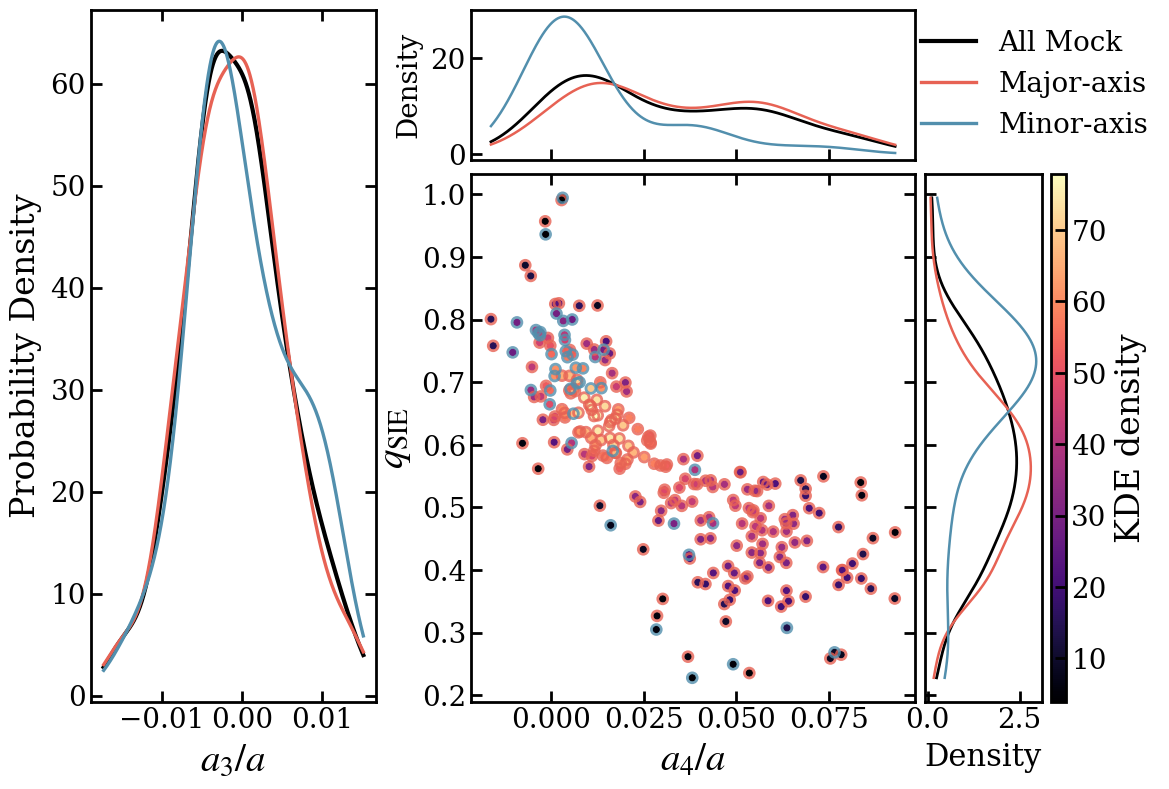

✅ Saved: a3_left_a4q_right.pdf


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
# - load_params()
# - colors
def make_combined_a3_left_a4q_right_from_df(
    save_path="a3_left_a4q_right.pdf"
):
    # ==========================================================
    # ==========================================================
    df = load_params("Theory_Mock/all_sim_Mul")
    if df.empty:
        raise RuntimeError("load_params() returned empty DataFrame.")
    a4_all = df["a4_over_a_signed"].to_numpy(dtype=float)
    q_all  = df["q"].to_numpy(dtype=float)
    a3_all = df["a3_over_a_signed"].to_numpy(dtype=float)
    m_all = np.isfinite(a4_all) & np.isfinite(q_all)
    a4_all, q_all = a4_all[m_all], q_all[m_all]
    a3_all = a3_all[np.isfinite(a3_all)]
    # --- Major / Minor ---
    dfL = df[df.axis_type == "long_axis"]
    dfS = df[df.axis_type == "short_axis"]
    a4_L = dfL["a4_over_a_signed"].to_numpy(dtype=float)
    q_L  = dfL["q"].to_numpy(dtype=float)
    a3_L = dfL["a3_over_a_signed"].to_numpy(dtype=float)
    a4_S = dfS["a4_over_a_signed"].to_numpy(dtype=float)
    q_S  = dfS["q"].to_numpy(dtype=float)
    a3_S = dfS["a3_over_a_signed"].to_numpy(dtype=float)
    mL = np.isfinite(a4_L) & np.isfinite(q_L)
    a4_L, q_L = a4_L[mL], q_L[mL]
    a3_L = a3_L[np.isfinite(a3_L)]
    mS = np.isfinite(a4_S) & np.isfinite(q_S)
    a4_S, q_S = a4_S[mS], q_S[mS]
    a3_S = a3_S[np.isfinite(a3_S)]
    # ==========================================================
    # ==========================================================
    max_points = 10000
    n_total = len(q_all)
    if n_total > max_points:
        idx = np.random.choice(n_total, size=max_points, replace=False)
        a4_sample = a4_all[idx]
        q_sample  = q_all[idx]
    else:
        a4_sample = a4_all
        q_sample  = q_all
    xy = np.vstack([a4_sample, q_sample])
    kde2d = gaussian_kde(xy)
    z = kde2d(xy)
    sort_idx = np.argsort(z)
    a4_sorted = a4_sample[sort_idx]
    q_sorted  = q_sample[sort_idx]
    z_sorted  = z[sort_idx]
    # ==========================================================
    # ==========================================================
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(
        6, 10, figure=fig,
        height_ratios=[0.9, 1.0, 1.0, 1.0, 0.25, 0.05],
        width_ratios=[1.00, 0.85, 0.5, 0.95, 0.95, 0.95, 0.78, 0.10, 0.55, 0.05],
        wspace=0.10,
        hspace=0.12
    )
    ax_a3    = fig.add_subplot(gs[0:4, 0:2])
    ax_main  = fig.add_subplot(gs[1:4, 3:6])
    ax_top   = fig.add_subplot(gs[0,   3:6], sharex=ax_main)
    ax_right = fig.add_subplot(gs[1:4, 6],   sharey=ax_main)
    cax      = fig.add_subplot(gs[1:4, 7])
    # ==========================================================
    # D) a4–q: ALL KDE + Major / Minor
    # ==========================================================
    sc = ax_main.scatter(
        a4_sorted, q_sorted,
        c=z_sorted, s=20,
        cmap="magma",
        rasterized=True
    )
    color_major = colors[0]
    color_minor = colors[-3]
    ax_main.scatter(a4_L, q_L, s=50, facecolor="none",
                    edgecolor=color_major, linewidth=2, alpha=0.8)
    ax_main.scatter(a4_S, q_S, s=50, facecolor="none",
                    edgecolor=color_minor, linewidth=2, alpha=0.8)
    ax_main.set_xlabel(r"$a_4/a$", fontsize=28)
    ax_main.set_ylabel(r"$q_{\rm SIE}$", fontsize=28)
    ax_main.tick_params(direction="in", top=True, right=True)
    cbar = fig.colorbar(sc, cax=cax)
    cbar.set_label("KDE density", fontsize=24)
    # --- top KDE: a4 ---
    x_vals = np.linspace(np.nanmin(a4_all), np.nanmax(a4_all), 800)
    ax_top.plot(x_vals, gaussian_kde(a4_all)(x_vals), color="k", lw=2)
    if len(a4_L) > 10:
        ax_top.plot(x_vals, gaussian_kde(a4_L)(x_vals), color=color_major, lw=1.8)
    if len(a4_S) > 10:
        ax_top.plot(x_vals, gaussian_kde(a4_S)(x_vals), color=color_minor, lw=1.8)
    ax_top.tick_params(labelbottom=False, direction="in")
    ax_top.set_ylabel("Density", fontsize=20)
    # --- right KDE: q ---
    y_vals = np.linspace(np.nanmin(q_all), np.nanmax(q_all), 800)
    ax_right.plot(gaussian_kde(q_all)(y_vals), y_vals, color="k", lw=2)
    if len(q_L) > 10:
        ax_right.plot(gaussian_kde(q_L)(y_vals), y_vals, color=color_major, lw=1.8)
    if len(q_S) > 10:
        ax_right.plot(gaussian_kde(q_S)(y_vals), y_vals, color=color_minor, lw=1.8)
    ax_right.tick_params(labelleft=False, direction="in")
    ax_right.set_xlabel("Density", fontsize=22)
    # ==========================================================
    # ==========================================================
    def qclip(arr, lo=0.5, hi=99.5):
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            return None, None
        return np.percentile(arr, lo), np.percentile(arr, hi)
    lo_all, hi_all = qclip(a3_all)
    lo_L, hi_L = qclip(a3_L)
    lo_S, hi_S = qclip(a3_S)
    lo = np.nanmin([lo_all, lo_L, lo_S])
    hi = np.nanmax([hi_all, hi_L, hi_S])
    xgrid = np.linspace(lo, hi, 800)
    def kde_safe(arr):
        arr = arr[(arr >= lo) & (arr <= hi)]
        return gaussian_kde(arr)(xgrid) if arr.size > 10 else np.zeros_like(xgrid)
    ax_a3.plot(xgrid, kde_safe(a3_all), lw=3, color="k")
    ax_a3.plot(xgrid, kde_safe(a3_L),   lw=2.4, color=color_major)
    ax_a3.plot(xgrid, kde_safe(a3_S),   lw=2.4, color=color_minor)
    ax_a3.set_xlabel(r"$a_3/a$", fontsize=28)
    ax_a3.set_ylabel("Probability Density", fontsize=24)
    ax_a3.tick_params(direction="in", top=True, right=True)
    # ==========================================================
    # F) Legend
    # ==========================================================
    legend_handles = [
        Line2D([0], [0], color="k", lw=3, label="All Mock"),
        Line2D([0], [0], color=color_major, lw=2.4, label="Major-axis"),
        Line2D([0], [0], color=color_minor, lw=2.4, label="Minor-axis"),
    ]
    fig.legend(
        handles=legend_handles,
        loc="upper left",
        bbox_to_anchor=(0.70, 0.885),
        frameon=False,
        fontsize=20
    )
    fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()
    print(f"OK Saved: {save_path}")
# === run ===
make_combined_a3_left_a4q_right_from_df()

# Multipole showcase plot

/tmp/ipykernel_67445/1421711170.py:199: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


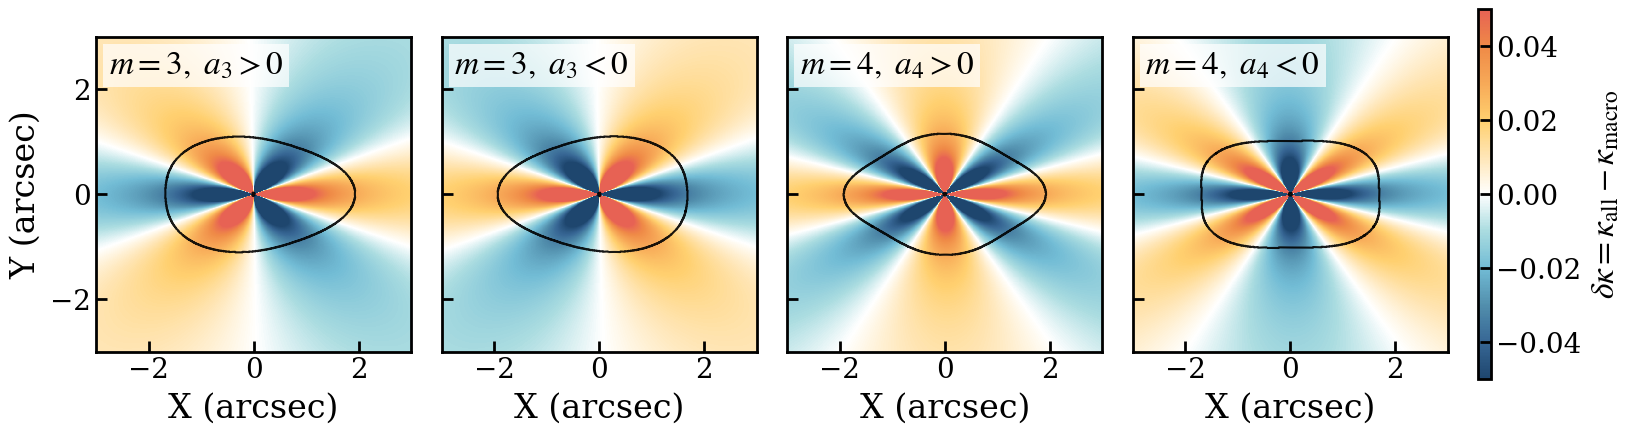

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from Lensing_tool import make_c_coor, alphas_to_mu
from show_kappa import plot_kappa, get_kappa, get_main_plan_kappa
from cal_mul_fits import to_elliptical_params, _shear_amp_pa_to_gamma
from lenstronomy.LensModel.lens_model import LensModel
def compute_alpha_multipole(
    m: int,
    a_over_a_signed: float,
    delta_phi_m: float,
    *,
    nnn: int = 1000,
    bsz_arc: float = 6.0,
    thetaE: float = 1.4,
    q_epl: float = 0.6,
    gamma_slope: float = 2.0,
    center_x: float = 0.0,
    center_y: float = 0.0,
    gamma_external: float = 0.0,
    phi_external: float = 0.0,
    phi_lens_deg: float = 0.0,
):
    """
    EPL + external shear + MULTIPOLE_ELL(m)
    Returns:
        alpha1_all, alpha2_all, alpha1_es, alpha2_es, xi1, xi2
        - alpha1/2_* : (nnn, nnn), (y,x)
        - xi1, xi2   : (nnn, nnn), (y,x)
    Notes:
        - lenstronomy  MULTIPOLE_ELL (q!=1) m=1/3/4
        -  m=3/4,  MULTIPOLE_ELL  q=q_epl( q=1)
        - a_over_a_signed "" a_m/a()
    """
    xi2, xi1 = make_c_coor(bsz_arc, nnn)  # (y, x)
    phi_rad = np.deg2rad(phi_lens_deg)
    e = (1.0 - q_epl) / (1.0 + q_epl)
    e1_sie = e * np.cos(2.0 * phi_rad)
    e2_sie = e * np.sin(2.0 * phi_rad)
    gamma1, gamma2 = _shear_amp_pa_to_gamma(gamma_external, phi_external)
    rescale_am = thetaE / np.sqrt(q_epl)
    a_m, phi_m = to_elliptical_params(
        m, a_over_a_signed, delta_phi_m, phi_rad, rescale_am
    )
    q_m = float(q_epl)
    kwargs_epl = {
        "theta_E": float(thetaE),
        "e1": float(e1_sie),
        "e2": float(e2_sie),
        "gamma": float(gamma_slope),
        "center_x": float(center_x),
        "center_y": float(center_y),
    }
    kwargs_shear = {"gamma1": float(gamma1), "gamma2": float(gamma2)}
    kwargs_mul = {
        "m": int(m),
        "a_m": float(a_m),
        "phi_m": float(phi_m),
        "q": float(q_m),
        "center_x": float(center_x),
        "center_y": float(center_y),
        "r_E": float(thetaE),
    }
    lens_all = LensModel(lens_model_list=["EPL", "SHEAR", "MULTIPOLE_ELL"])
    alpha_y, alpha_x = lens_all.alpha(
        xi2.ravel(), xi1.ravel(),
        kwargs=[kwargs_epl, kwargs_shear, kwargs_mul]
    )
    alpha1_all = np.asarray(alpha_x).reshape(nnn, nnn)
    alpha2_all = np.asarray(alpha_y).reshape(nnn, nnn)
    lens_es = LensModel(lens_model_list=["EPL", "SHEAR"])
    alpha_y_es, alpha_x_es = lens_es.alpha(
        xi2.ravel(), xi1.ravel(),
        kwargs=[kwargs_epl, kwargs_shear]
    )
    alpha1_es = np.asarray(alpha_x_es).reshape(nnn, nnn)
    alpha2_es = np.asarray(alpha_y_es).reshape(nnn, nnn)
    return alpha1_all, alpha2_all, alpha1_es, alpha2_es, xi1, xi2
# ==========================================================
# ==========================================================
if __name__ == "__main__":
    nnn = 1000
    bsz_arc = 6.0
    dsx_arc = bsz_arc / nnn
    amp3 = 0.05
    amp4 = 0.05
    dphi3 = 0.0136
    dphi4 = 0.0136
    vmin, vmax = -0.05, 0.05
    # (m, signed a_m/a, delta_phi, label)
    cases = [
        (3, +amp3, dphi3, r"$m=3,\ a_3>0$"),
        (3, -amp3, dphi3, r"$m=3,\ a_3<0$"),
        (4, +amp4, dphi4, r"$m=4,\ a_4>0$"),
        (4, -amp4, dphi4, r"$m=4,\ a_4<0$"),
    ]
    fig = plt.figure(figsize=(18, 4.8))
    gs = gridspec.GridSpec(
        1, 5,
        width_ratios=[1, 1, 1, 1, 0.04],
        wspace=0.12, hspace=0.0
    )
    axes = [fig.add_subplot(gs[0, i]) for i in range(4)]
    cax = fig.add_subplot(gs[0, 4])
    im_last = None
    for i, (ax, (m_val, a_signed, dphi, label)) in enumerate(zip(axes, cases)):
        alpha1_all, alpha2_all, alpha1_es, alpha2_es, xi1, xi2 = compute_alpha_multipole(
            m=m_val,
            a_over_a_signed=a_signed,
            delta_phi_m=dphi,
            nnn=nnn,
            bsz_arc=bsz_arc,
            thetaE=1.4,
            q_epl=0.6,
            gamma_slope=2.0,
            gamma_external=0.0,
            phi_external=0.0,
            phi_lens_deg=0.0,
        )
        yi1, yi2, mu_all, kappa_all, g1_all, g2_all = alphas_to_mu(
            alpha1_all, alpha2_all, dsx_arc, xi1, xi2
        )
        _, _, _, kappa_es, _, _ = alphas_to_mu(
            alpha1_es, alpha2_es, dsx_arc, xi1, xi2
        )
        delta_kappa = kappa_all - kappa_es
        im = plot_kappa(
            ax, delta_kappa, mu_all, bsz_arc, nnn,
            vmin=vmin, vmax=vmax
        )
        im_last = im
        ax.text(
            0.04, 0.96, label,
            transform=ax.transAxes,
            fontsize=24,
            va="top", ha="left",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7),
        )
        if i in (1, 2, 3):
            ax.set_ylabel("")
            ax.tick_params(labelleft=False)
    cb = fig.colorbar(im_last, cax=cax)
    cb.set_label(r"$\delta\kappa = \kappa_{\rm all} - \kappa_{\rm macro}$", fontsize=24)
    fig.savefig("multipoleShow.png", dpi=300, bbox_inches="tight", pad_inches=0.02)
    plt.tight_layout()
    plt.show()